In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from CIMtools.preprocessing import Fragmentor
from CIMtools.preprocessing import solvent
from os import environ

## environ['PATH']+=":/home/pavel/envs/cgr/bin"
## needs to be reassigned if ISIDA descriptor generation is needed

from CGRtools import RDFRead, MoleculeContainer, ReactionContainer, SDFRead, SMILESRead, smiles, CGRContainer
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold, cross_val_predict
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVR
from sklearn.datasets import load_svmlight_file, dump_svmlight_file
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error as mae

from scipy.optimize import curve_fit

from cheminfotools.chem_features import Augmentor, ComplexFragmentor, PassThrough, Pruner

%config IPCompleter.use_jedi = False
cm = 1./2.54

## Useful functions for calculations and reporting

The formula to translate enantiomers fractions to $\Delta\Delta G$ is coded here and applied:

$$\Delta\Delta G = RT\ln \frac{[R]}{[S]} = RT \ln \frac{fr}{100-{fr}}$$

$$ fr = 100 \times   e^{\frac{\Delta\Delta G}{RT}} / \left( 1+e^{\frac{\Delta\Delta G}{RT}} \right)$$

In [2]:
# Here, T is considered to be in K
def fraction2ddg(fr, T):
    return 0.008314461536*T*np.log(fr/(100-fr))

def ddg2fraction(ddg, T):
    return 100*np.exp(ddg/(0.008314461536*T))/(1+np.exp(ddg/(0.008314461536*T)))

In [3]:
def r2(a, b):
    return 1. - np.sum((a-b)**2)/np.sum((a-np.mean(a))**2)

def rmse(a, b):
    return np.sqrt(np.sum((a-b)**2)/len(a))

def vs_plot(a, b, show=True, rmse_line=False, title='', format_as_fractions=False):
    from matplotlib.ticker import FuncFormatter
    fig, ax = plt.subplots(figsize=(5,5), dpi=300, facecolor="white")
    
    def format_tick_labels(x, pos):
        return '{}:{}'.format(int(x*100), 100-int(x*100))

    ax.plot(a, b, 'bo')
    ax.plot([min(a), max(a)], [min(a), max(a)], "k--")
    ax.set_xlabel("Observed")
    ax.set_ylabel("Predicted")
    if title:
        ax.set_title(title)
    if rmse_line:
        ax.plot([min(a), max(a)-rmse(a,b)], [min(a)+rmse(a,b), max(a)], "r--")
        ax.plot([min(a)+rmse(a,b), max(a)], [min(a), max(a)-rmse(a,b)], "r--")
    if format_as_fractions:
        ax.xaxis.set_major_formatter(FuncFormatter(format_tick_labels))
        ax.yaxis.set_major_formatter(FuncFormatter(format_tick_labels))
    if show:
        plt.show()
    return fig, ax

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectorMixin
    
def libsvm_parser(params_line):
    params = params_line.split(" ")
    c = float(params[params.index("-c")+1])
    coef0 = float(params[params.index("-r")+1])
    epsilon = float(params[params.index("-p")+1])
    kernel = int(params[params.index("-t")+1])
    if kernel == 0:
        kernel = "linear"
    elif kernel == 1:
        kernel = "poly"
    elif kernel == 2:
        kernel = "rbf"
    elif kernel == 3:
        kernel = "sigmoid"
    
    return SVR(kernel=kernel, gamma="auto", coef0=coef0, C=c, epsilon=epsilon)

## Loading the master data file

In [6]:
data_THF = pd.read_excel("THF_THP_data.xls", sheet_name="THF")
data_THP_train = pd.read_excel("THF_THP_data.xls", sheet_name="THP")
data_THP_test = pd.read_excel("THF_THP_data.xls", sheet_name="External validation")

# since we don't have descriptors for methylcyclohexane, we consider them equal to cyclohexane
data_THP_train.loc[data_THP_train["solvent"] == "methylcyclohexane","solvent"] = "cyclohexane"

ddg_THF = np.array(data_THF.ddG)
ddg_THF_calib = data_THF["ddG calib (C=0.05)"]
ddg_THP_train = np.array(data_THP_train.ddG)
ddg_THP_test = np.array(data_THP_test.ddG)

# transforming SMILES to structures - THF
full_structures = []
Ar_structures = []
R_structures = []
for i, row in data_THF.iterrows():
    full_structures.append(smiles(row["SMILES"]))
    full_structures[-1].clean2d()

    r = smiles(row["Ar"])
    p = smiles(row["Ar"])
    p.delete_bond(1,2)
    Ar_structures.append(r.compose(p))
    Ar_structures[-1].clean2d()
    R_structures.append(smiles(row["R"]))
    R_structures[-1].clean2d()
    
data_THF["mol_full"] = full_structures
data_THF["mol_Ar"] = Ar_structures
data_THF["mol_R"] = R_structures

# transforming SMILES to structures - THP train
full_structures = []
Ar_structures = []
R_structures = []
for i, row in data_THP_train.iterrows():
    full_structures.append(smiles(row["SMILES"]))
    full_structures[-1].clean2d()

    r = smiles(row["Ar"])
    p = smiles(row["Ar"])
    p.delete_bond(1,2)
    Ar_structures.append(r.compose(p))
    Ar_structures[-1].clean2d()
    R_structures.append(smiles(row["R"]))
    R_structures[-1].clean2d()
    
data_THP_train["mol_full"] = full_structures
data_THP_train["mol_Ar"] = Ar_structures
data_THP_train["mol_R"] = R_structures

# transforming SMILES to structures - THP test
full_structures = []
Ar_structures = []
R_structures = []
for i, row in data_THP_test.iterrows():
    full_structures.append(smiles(row["SMILES"]))
    full_structures[-1].clean2d()

    r = smiles(row["Ar"])
    p = smiles(row["Ar"])
    p.delete_bond(1,2)
    Ar_structures.append(r.compose(p))
    Ar_structures[-1].clean2d()
    R_structures.append(smiles(row["R"]))
    R_structures[-1].clean2d()
    
data_THP_test["mol_full"] = full_structures
data_THP_test["mol_Ar"] = Ar_structures
data_THP_test["mol_R"] = R_structures

THP_reaction = smiles("[OH:3][CH2:7][CH2:6][CH2:5][CH2:4][C:1](=[CH2:2])[c:8]1[cH:9][cH:10][cH:11][cH:12][cH:13]1>>[CH3:2][C:1]1([CH2:4][CH2:5][CH2:6][CH2:7][O:3]1)[c:8]1[cH:9][cH:10][cH:11][cH:12][cH:13]1")
THP_reaction.clean2d()
THP_cgr = THP_reaction.compose()
THF_reaction = smiles("[OH:3][CH2:4][CH2:5][CH2:6][C:1](=[CH2:2])[c:7]1[cH:8][cH:9][cH:10][cH:11][cH:12]1>>[CH3:2][C:1]1([CH2:6][CH2:5][CH2:4][O:3]1)[c:7]1[cH:8][cH:9][cH:10][cH:11][cH:12]1")
THF_reaction.clean2d()
THF_cgr = THF_reaction.compose()

data_THF["CGR"] = [THF_cgr]*len(data_THF)
data_THP_train["CGR"] = [THP_cgr]*len(data_THP_train)
data_THP_test["CGR"] = [THP_cgr]*len(data_THP_test)

## Calibration by concentration

In [7]:
data_calib_tol = pd.read_excel("THF_THP_data.xls", sheet_name="Calibration by C (Tol)")

ddg_calib_tol = data_calib_tol["ddG"]

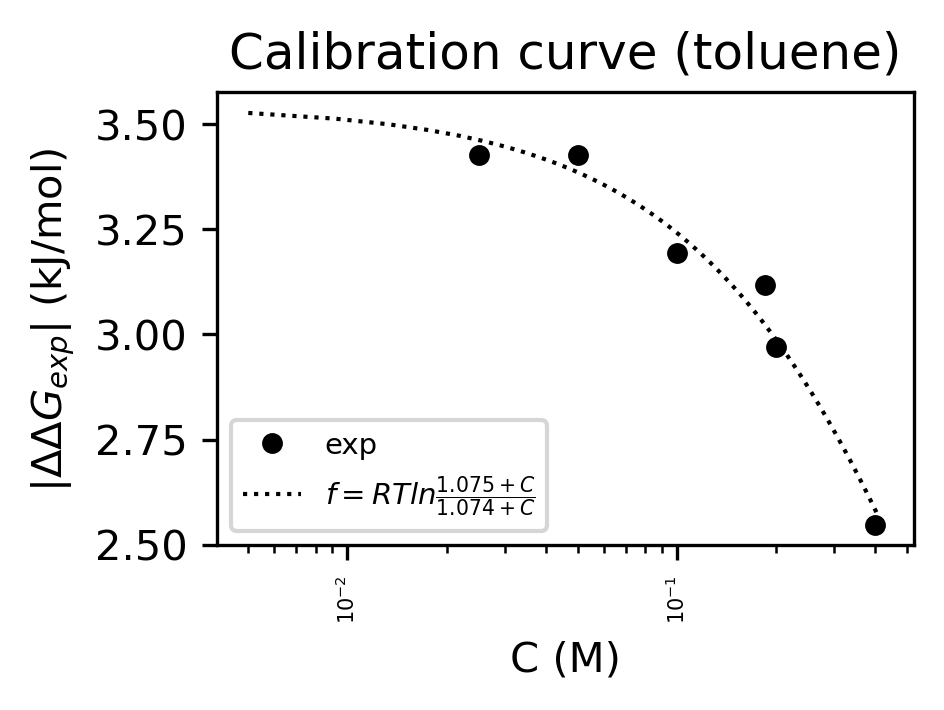

In [9]:
def calib_function(x, a, b, T=333.15):
    return 8.31*T*np.log((a+x)/(b+x))

tol_calib_coef, tol_pcovb = curve_fit(lambda x,a,b:calib_function(x,a,b, T=np.array(data_calib_tol["T(K)"])), 
                           np.array(data_calib_tol["concentration"]), 
                           ddg_calib_tol, p0=(1,1))

curve_x = np.linspace(np.array(data_calib_tol["concentration"]).min()-0.02,
                    np.array(data_calib_tol["concentration"]).max()+0.02, 100)

fig, ax = plt.subplots(figsize=(3, 2), dpi=300, facecolor="white")
ax.semilogx(np.array(data_calib_tol["concentration"]), ddg_calib_tol, "ko",  markersize=4)
ax.semilogx(curve_x, calib_function(curve_x, *tol_calib_coef), "k", linewidth=1 , linestyle="dotted" )
plt.xlabel("C (M)")
plt.ylabel(r"|$\Delta\Delta G_{exp}$| (kJ/mol)")
plt.legend(["exp",
            r"$f=RTln\frac{"+str(np.round(tol_calib_coef[0], 3))+"+C}{"+str(np.round(tol_calib_coef[1], 3))+"+C}$"], 
           fontsize=7)
plt.setp(ax.get_xmajorticklabels(), rotation=90, fontsize=5)
plt.setp(ax.get_xminorticklabels(), rotation=90, fontsize=5)
plt.title("Calibration curve (toluene)")
plt.show()

In [10]:
data_calib_cyh = pd.read_excel("THF_THP_data.xls", sheet_name="Calibration by C (CyH)")

ddg_calib_cyh = data_calib_cyh["ddG"]

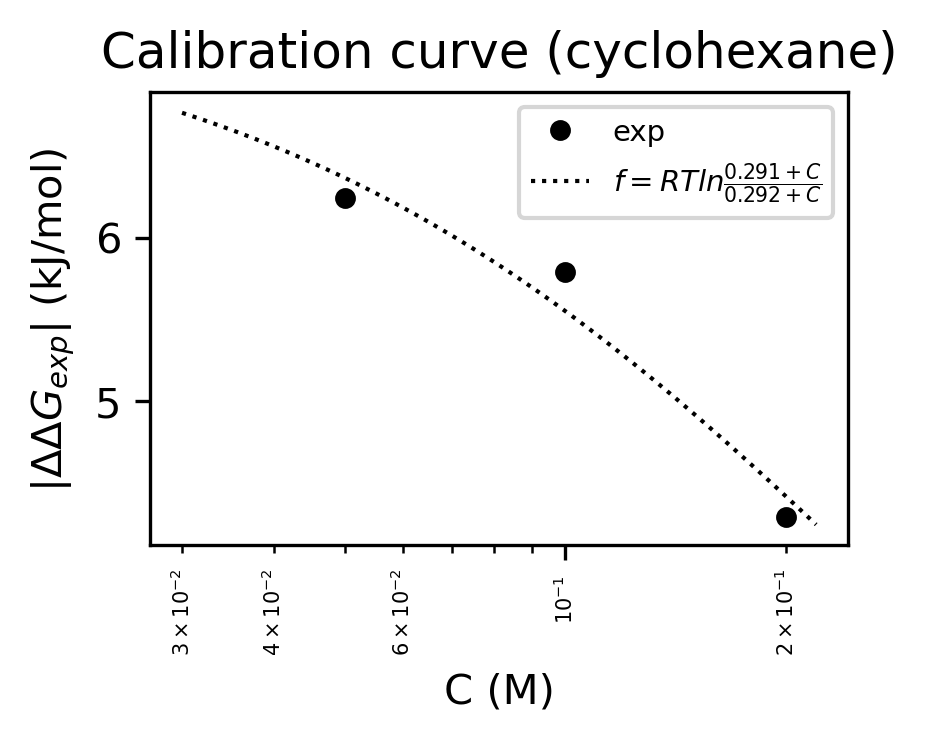

In [11]:
cyh_calib_coef, cyh_pcovb = curve_fit(lambda x,a,b:calib_function(x,a,b, T=np.array(data_calib_cyh["T(K)"])), 
                           np.array(data_calib_cyh["concentration"]), 
                           ddg_calib_cyh, p0=(1,1))

curve_x = np.linspace(np.array(data_calib_cyh["concentration"]).min()-0.02,
                    np.array(data_calib_cyh["concentration"]).max()+0.02, 100)

fig, ax = plt.subplots(figsize=(3, 2), dpi=300, facecolor="white")
ax.semilogx(np.array(data_calib_cyh["concentration"]), -ddg_calib_cyh, "ko",  markersize=4)
ax.semilogx(curve_x, -calib_function(curve_x, *cyh_calib_coef), "k", linewidth=1 , linestyle="dotted" )
plt.xlabel("C (M)")
plt.ylabel(r"|$\Delta\Delta G_{exp}$| (kJ/mol)")
plt.legend(["exp",
            r"$f=RTln\frac{"+str(np.round(cyh_calib_coef[0], 3))+"+C}{"+str(np.round(cyh_calib_coef[1], 3))+"+C}$"], 
           fontsize=7)
plt.setp(ax.get_xmajorticklabels(), rotation=90, fontsize=5)
plt.setp(ax.get_xminorticklabels(), rotation=90, fontsize=5)
plt.title("Calibration curve (cyclohexane)")
plt.show()

In [12]:
def calibrate(x, initial_conc, final_conc, coef, T, f=calib_function):
    y = f(final_conc, *coef, T=T)*np.abs(x)/f(initial_conc, *coef, T=T)*((x>0).astype(int)*2-1)
    return np.array(y)

## Best models by descriptor type

### Models with default parameters

In [10]:
import glob
import xgboost
from catboost import CatBoostRegressor

default_models = pd.DataFrame()

for i, f in enumerate(glob.glob('Benchmark/*')):
    dtype = pd.read_table(f+'/best_pop', delimiter=' ', header=None).iloc[0][0]
    default_models = default_models.append({'descriptors':'_'.join(f.split('/')[-1].split('_')[1:])}, ignore_index=True)
    desc, _ = load_svmlight_file(f+'/'+dtype+'.scaled.svm')
    desc = desc.toarray()
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        svr = SVR(kernel=kernel)
        res = cross_val_predict(svr, desc, ddg_THF_calib, cv=len(ddg_THF_calib))
        default_models.at[i, 'SVR-'+kernel] = mae(ddg_THF_calib, res)
    rf = RandomForestRegressor()
    res = cross_val_predict(rf, desc, ddg_THF_calib, cv=len(ddg_THF_calib))
    default_models.at[i, 'RF'] = mae(ddg_THF_calib, res)
    xgb = xgboost.XGBRegressor()
    res = cross_val_predict(xgb, desc, ddg_THF_calib, cv=len(ddg_THF_calib))
    default_models.at[i, 'XGBoost'] = mae(ddg_THF_calib, res)
    cbr = CatBoostRegressor(silent=True)
    res = cross_val_predict(cbr, desc, ddg_THF_calib, cv=len(ddg_THF_calib))
    default_models.at[i, 'CatBoost'] = mae(ddg_THF_calib, res)


,descriptors,SVR-linear,SVR-poly,SVR-rbf,SVR-sigmoid,RF,XGBoost
0,mfp04_full,1.223211,1.676633,1.806862,1.800314,1.275628,1.538431
1,isida_full,0.881438,1.355481,1.248430,1.690189,0.993284,1.065824
2,rdkfp_full,1.592452,1.568321,1.825971,2.860904,1.521665,1.447364
3,mfp04_solvent,1.183358,1.970189,1.938100,1.714764,1.029739,1.225690
4,rdkfp_solvent,1.610725,1.740641,1.800154,2.750659,1.213741,1.077607
5,mfp_full,1.223211,1.676633,1.806862,1.800314,1.298693,1.538431
6,rdkfp_full_solvent,1.710711,1.662626,1.969685,2.532277,1.280420,1.430853
7,MFF_solvent,1.064800,1.528680,1.629480,2.129086,0.853901,0.813864
8,torsion,0.924276,1.482657,1.526585,1.499719,1.024306,1.189047
9,MFF,1.013392,1.527251,1.625600,2.132794,1.051318,0.967883


### Benchmarking study on THF

In [ ]:
# Descriptors generation
# DO NOT RELAUNCH unless new optimization is needed!!!!!

# from rdkit import Chem
# from rdkit.Chem import AllChem

# desc_names = []
# for k in [6,9]:
#     for i in range(3,6):
#         desc_names.append("isida"+str(k)+"-1-"+str(i))
        
# for k in [3]:
#     for i in range(5,9):
#         desc_names.append("isida"+str(k)+"-2-"+str(i))

# for i in range(2,5):
#     desc_names.append("sub-0-"+str(i))  
    
# desc_names.append("mfp4")

# for s in [{}, data_THF["solvent"]]:
#     for c in ("mol_full", "mol_Ar"):
#         for d in desc_names:
#             n = d
#             if d.startswith("isida"):
#                 fr_type = int(d[5:].split("-")[-3])
#                 fr_lower = int(d.split("-")[-2])
#                 fr_upper = int(d.split("-")[-1])
#                 df = Fragmentor(fragment_type=fr_type,min_length=fr_lower, max_length=fr_upper)
#                 frags_train = df.fit_transform(data_THF[c])
#                 #frags_test = df.transform(data_c_test)
#             elif d.startswith("sub"):
#                 fr_lower = int(d[3:].split("-")[-2])
#                 fr_upper = int(d[3:].split("-")[-1])
#                 df = Augmentor(lower=fr_lower, upper=fr_upper)
#                 frags_train = df.fit_transform(data_THF[c])
#                 #frags_test = df.transform(data_c_test)
#             elif d.startswith("mfp"):
#                 mfp = []
                
#                 for i, row in data_THF.iterrows():
#                     if c == "mol_full":
#                         mol = Chem.MolFromSmiles(row["SMILES"])
#                     else:
#                         mol = Chem.MolFromSmiles(row["Ar"])
#                     mfp.append(AllChem.GetMorganFingerprintAsBitVect(mol,4,nBits=1024))

#                 frags_train = pd.DataFrame(np.array(mfp))
            
#             s_folder = ""
#             if len(s):
#                 frags_train = pd.concat([frags_train, 
#                                          solvent.SolventVectorizer().fit_transform(s)], axis=1, sort=False)
#                 s_folder = "_solvent"
#                 n = n + "+solvent"

#             if c == "mol_full":
#                 if d.startswith("isida"):
#                     dump_svmlight_file(frags_train, ddg_THF_calib, 
#                                        "Descriptors_THF_benchmark/isida_full"+s_folder+"/"+n+".svm", zero_based=False)
#                     np.savetxt("Descriptors_THF_benchmark/isida_full"+s_folder+"/ref.SVMreg", ddg_THF_calib, fmt="%g")
#                 elif d.startswith("sub"):
#                     dump_svmlight_file(frags_train, ddg_THF_calib, 
#                                        "Descriptors_THF_benchmark/sub_full"+s_folder+"/"+n+".svm", zero_based=False)
#                     np.savetxt("Descriptors_THF_benchmark/sub_full"+s_folder+"/ref.SVMreg", ddg_THF_calib, fmt="%g")
#                 if d.startswith("mfp"):
#                     dump_svmlight_file(frags_train, ddg_THF_calib, 
#                                        "Descriptors_THF_benchmark/mfp_full"+s_folder+"/"+n+".svm", zero_based=False)
#                     np.savetxt("Descriptors_THF_benchmark/mfp_full"+s_folder+"/ref.SVMreg", ddg_THF_calib, fmt="%g")
#             else:
#                 if d.startswith("isida"):
#                     dump_svmlight_file(frags_train, ddg_THF_calib, 
#                                        "Descriptors_THF_benchmark/isida"+s_folder+"/"+n+".svm", zero_based=False)
#                     np.savetxt("Descriptors_THF_benchmark/isida"+s_folder+"/ref.SVMreg", ddg_THF_calib, fmt="%g")
#                 elif d.startswith("sub"):
#                     dump_svmlight_file(frags_train, ddg_THF_calib, 
#                                        "Descriptors_THF_benchmark/sub"+s_folder+"/"+n+".svm", zero_based=False)
#                     np.savetxt("Descriptors_THF_benchmark/sub"+s_folder+"/ref.SVMreg", ddg_THF_calib, fmt="%g")
#                 if d.startswith("mfp"):
#                     dump_svmlight_file(frags_train, ddg_THF_calib, 
#                                        "Descriptors_THF_benchmark/mfp"+s_folder+"/"+n+".svm", zero_based=False)
#                     np.savetxt("Descriptors_THF_benchmark/mfp"+s_folder+"/ref.SVMreg", ddg_THF_calib, fmt="%g")
            

In [20]:
best_model_isida = pd.read_table("Benchmark/Benchmark_isida/best_pop", header=None, delimiter=" ").iloc[0]
best_model_circus = pd.read_table("Benchmark/Benchmark_sub/best_pop", header=None, delimiter=" ").iloc[0]
best_model_mfp = pd.read_table("Benchmark/Benchmark_mfp04/best_pop", header=None, delimiter=" ").iloc[0]
best_model_isida_solv = pd.read_table("Benchmark/Benchmark_isida_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_circus_solv = pd.read_table("Benchmark/Benchmark_sub_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_mfp_solv = pd.read_table("Benchmark/Benchmark_mfp04_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_isida_full_solv = pd.read_table("Benchmark/Benchmark_isida_full_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_circus_full_solv = pd.read_table("Benchmark/Benchmark_sub_full_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_mfp_full_solv = pd.read_table("Benchmark/Benchmark_mfp04_full_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_isida_full = pd.read_table("Benchmark/Benchmark_isida_full/best_pop", header=None, delimiter=" ").iloc[0]
best_model_circus_full = pd.read_table("Benchmark/Benchmark_sub_full/best_pop", header=None, delimiter=" ").iloc[0]
best_model_mfp_full = pd.read_table("Benchmark/Benchmark_mfp04_full/best_pop", header=None, delimiter=" ").iloc[0]
best_model_avalon = pd.read_table("Benchmark/Benchmark_avalon/best_pop", header=None, delimiter=" ").iloc[0]
best_model_avalon_full = pd.read_table("Benchmark/Benchmark_avalon_full/best_pop", header=None, delimiter=" ").iloc[0]
best_model_avalon_solv = pd.read_table("Benchmark/Benchmark_avalon_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_avalon_full_solv = pd.read_table("Benchmark/Benchmark_avalon_full_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_rdkfp = pd.read_table("Benchmark/Benchmark_rdkfp/best_pop", header=None, delimiter=" ").iloc[0]
best_model_rdkfp_full = pd.read_table("Benchmark/Benchmark_rdkfp_full/best_pop", header=None, delimiter=" ").iloc[0]
best_model_rdkfp_solv = pd.read_table("Benchmark/Benchmark_rdkfp_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_rdkfp_full_solv = pd.read_table("Benchmark/Benchmark_rdkfp_full_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_torsion = pd.read_table("Benchmark/Benchmark_torsion/best_pop", header=None, delimiter=" ").iloc[0]
best_model_torsion_full = pd.read_table("Benchmark/Benchmark_torsion_full/best_pop", header=None, delimiter=" ").iloc[0]
best_model_torsion_solv = pd.read_table("Benchmark/Benchmark_torsion_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_torsion_full_solv = pd.read_table("Benchmark/Benchmark_torsion_full_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_ap = pd.read_table("Benchmark/Benchmark_ap/best_pop", header=None, delimiter=" ").iloc[0]
best_model_ap_full = pd.read_table("Benchmark/Benchmark_ap_full/best_pop", header=None, delimiter=" ").iloc[0]
best_model_ap_solv = pd.read_table("Benchmark/Benchmark_ap_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_ap_full_solv = pd.read_table("Benchmark/Benchmark_ap_full_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_mff = pd.read_table("Benchmark/Benchmark_MFF/best_pop", header=None, delimiter=" ").iloc[0]
best_model_mff_full = pd.read_table("Benchmark/Benchmark_MFF_full/best_pop", header=None, delimiter=" ").iloc[0]
best_model_mff_solv = pd.read_table("Benchmark/Benchmark_MFF_solvent/best_pop", header=None, delimiter=" ").iloc[0]
best_model_mff_full_solv = pd.read_table("Benchmark/Benchmark_MFF_full_solvent/best_pop", header=None, delimiter=" ").iloc[0]


In [14]:
results_best_model_circus_full_solv = np.loadtxt("Benchmark/Benchmark_sub_full_solvent/"+best_model_circus_full_solv[8]+"/final_test.pred.gz")
results_best_model_circus_full = np.loadtxt("Benchmark/Benchmark_sub_full/"+best_model_circus_full[8]+"/final_test.pred.gz")
results_best_model_isida_full_solv = np.loadtxt("Benchmark/Benchmark_isida_full_solvent/"+best_model_isida_full_solv[8]+"/final_test.pred.gz")
results_best_model_isida_full = np.loadtxt("Benchmark/Benchmark_isida_full/"+best_model_isida_full[8]+"/final_test.pred.gz")
results_best_model_mfp_full_solv = np.loadtxt("Benchmark/Benchmark_mfp04_full_solvent/"+best_model_mfp_full_solv[8]+"/final_test.pred.gz")
results_best_model_mfp_full = np.loadtxt("Benchmark/Benchmark_mfp04_full/"+best_model_mfp_full[8]+"/final_test.pred.gz")
results_best_model_avalon_full_solv = np.loadtxt("Benchmark/Benchmark_avalon_full_solvent/"+best_model_avalon_full_solv[8]+"/final_test.pred.gz")
results_best_model_avalon_full = np.loadtxt("Benchmark/Benchmark_avalon_full/"+best_model_avalon_full[8]+"/final_test.pred.gz")
results_best_model_rdkfp_full_solv = np.loadtxt("Benchmark/Benchmark_rdkfp_full_solvent/"+best_model_rdkfp_full_solv[8]+"/final_test.pred.gz")
results_best_model_rdkfp_full = np.loadtxt("Benchmark/Benchmark_rdkfp_full/"+best_model_rdkfp_full[8]+"/final_test.pred.gz")
results_best_model_torsion_full_solv = np.loadtxt("Benchmark/Benchmark_torsion_full_solvent/"+best_model_torsion_full_solv[8]+"/final_test.pred.gz")
results_best_model_torsion_full = np.loadtxt("Benchmark/Benchmark_torsion_full/"+best_model_torsion_full[8]+"/final_test.pred.gz")
results_best_model_ap_full_solv = np.loadtxt("Benchmark/Benchmark_ap_full_solvent/"+best_model_ap_full_solv[8]+"/final_test.pred.gz")
results_best_model_ap_full = np.loadtxt("Benchmark/Benchmark_ap_full/"+best_model_ap_full[8]+"/final_test.pred.gz")
results_best_model_mff_full_solv = np.loadtxt("Benchmark/Benchmark_MFF_full_solvent/"+best_model_mff_full_solv[8]+"/final_test.pred.gz")
results_best_model_mff_full = np.loadtxt("Benchmark/Benchmark_MFF_full/"+best_model_mff_full[8]+"/final_test.pred.gz")

results_best_model_circus_solv = np.loadtxt("Benchmark/Benchmark_sub_solvent/"+best_model_circus_solv[8]+"/final_test.pred.gz")
results_best_model_circus = np.loadtxt("Benchmark/Benchmark_sub/"+best_model_circus[8]+"/final_test.pred.gz")
results_best_model_isida_solv = np.loadtxt("Benchmark/Benchmark_isida_solvent/"+best_model_isida_solv[8]+"/final_test.pred.gz")
results_best_model_isida = np.loadtxt("Benchmark/Benchmark_isida/"+best_model_isida[8]+"/final_test.pred.gz")
results_best_model_mfp_solv = np.loadtxt("Benchmark/Benchmark_mfp04_solvent/"+best_model_mfp_solv[8]+"/final_test.pred.gz")
results_best_model_mfp = np.loadtxt("Benchmark/Benchmark_mfp04/"+best_model_mfp[8]+"/final_test.pred.gz")
results_best_model_avalon_solv = np.loadtxt("Benchmark/Benchmark_avalon_solvent/"+best_model_avalon_solv[8]+"/final_test.pred.gz")
results_best_model_avalon = np.loadtxt("Benchmark/Benchmark_avalon/"+best_model_avalon[8]+"/final_test.pred.gz")
results_best_model_rdkfp_solv = np.loadtxt("Benchmark/Benchmark_rdkfp_solvent/"+best_model_rdkfp_solv[8]+"/final_test.pred.gz")
results_best_model_rdkfp = np.loadtxt("Benchmark/Benchmark_rdkfp/"+best_model_rdkfp[8]+"/final_test.pred.gz")
results_best_model_torsion_solv = np.loadtxt("Benchmark/Benchmark_torsion_solvent/"+best_model_torsion_solv[8]+"/final_test.pred.gz")
results_best_model_torsion = np.loadtxt("Benchmark/Benchmark_torsion/"+best_model_torsion[8]+"/final_test.pred.gz")
results_best_model_ap_solv = np.loadtxt("Benchmark/Benchmark_ap_solvent/"+best_model_ap_solv[8]+"/final_test.pred.gz")
results_best_model_ap = np.loadtxt("Benchmark/Benchmark_ap/"+best_model_ap[8]+"/final_test.pred.gz")
results_best_model_mff_solv = np.loadtxt("Benchmark/Benchmark_MFF_solvent/"+best_model_mff_solv[8]+"/final_test.pred.gz")
results_best_model_mff = np.loadtxt("Benchmark/Benchmark_MFF/"+best_model_mff[8]+"/final_test.pred.gz")

In [15]:
full_structure_r2 = [[r2(results_best_model_circus_full_solv[:,1], results_best_model_circus_full_solv[:,i]) for i in range(2,results_best_model_circus_full_solv.shape[1])],
          [r2(results_best_model_circus_full[:,1], results_best_model_circus_full[:,i]) for i in range(2,results_best_model_circus_full.shape[1])],
          [r2(results_best_model_isida_full_solv[:,1], results_best_model_isida_full_solv[:,i]) for i in range(2,results_best_model_isida_full_solv.shape[1])],
          [r2(results_best_model_isida_full[:,1], results_best_model_isida_full[:,i]) for i in range(2,results_best_model_isida_full.shape[1])],
          [r2(results_best_model_avalon_full_solv[:,1], results_best_model_avalon_full_solv[:,i]) for i in range(2,results_best_model_avalon_full_solv.shape[1])],
          [r2(results_best_model_avalon_full[:,1], results_best_model_avalon_full[:,i]) for i in range(2,results_best_model_avalon_full.shape[1])],
          [r2(results_best_model_mfp_full_solv[:,1], results_best_model_mfp_full_solv[:,i]) for i in range(2,results_best_model_mfp_full_solv.shape[1])],
          [r2(results_best_model_mfp_full[:,1], results_best_model_mfp_full[:,i]) for i in range(2,results_best_model_mfp_full.shape[1])],
          [r2(results_best_model_mff_full_solv[:,1], results_best_model_mff_full_solv[:,i]) for i in range(2,results_best_model_mff_full_solv.shape[1])],
          [r2(results_best_model_mff_full[:,1], results_best_model_mff_full[:,i]) for i in range(2,results_best_model_mff_full.shape[1])],
          [r2(results_best_model_ap_full_solv[:,1], results_best_model_ap_full_solv[:,i]) for i in range(2,results_best_model_ap_full_solv.shape[1])],
          [r2(results_best_model_ap_full[:,1], results_best_model_ap_full[:,i]) for i in range(2,results_best_model_ap_full.shape[1])],
          [r2(results_best_model_torsion_full_solv[:,1], results_best_model_torsion_full_solv[:,i]) for i in range(2,results_best_model_torsion_full_solv.shape[1])],
          [r2(results_best_model_torsion_full[:,1], results_best_model_torsion_full[:,i]) for i in range(2,results_best_model_torsion_full.shape[1])],
          [r2(results_best_model_rdkfp_full_solv[:,1], results_best_model_rdkfp_full_solv[:,i]) for i in range(2,results_best_model_rdkfp_full_solv.shape[1])],
          [r2(results_best_model_rdkfp_full[:,1], results_best_model_rdkfp_full[:,i]) for i in range(2,results_best_model_rdkfp_full.shape[1])]]

full_structure_mae = [[mae(results_best_model_circus_full_solv[:,1], results_best_model_circus_full_solv[:,i]) for i in range(2,results_best_model_circus_full_solv.shape[1])],
          [mae(results_best_model_circus_full[:,1], results_best_model_circus_full[:,i]) for i in range(2,results_best_model_circus_full.shape[1])],
          [mae(results_best_model_isida_full_solv[:,1], results_best_model_isida_full_solv[:,i]) for i in range(2,results_best_model_isida_full_solv.shape[1])],
          [mae(results_best_model_isida_full[:,1], results_best_model_isida_full[:,i]) for i in range(2,results_best_model_isida_full.shape[1])],
          [mae(results_best_model_avalon_full_solv[:,1], results_best_model_avalon_full_solv[:,i]) for i in range(2,results_best_model_avalon_full_solv.shape[1])],
          [mae(results_best_model_avalon_full[:,1], results_best_model_avalon_full[:,i]) for i in range(2,results_best_model_avalon_full.shape[1])],
          [mae(results_best_model_mfp_full_solv[:,1], results_best_model_mfp_full_solv[:,i]) for i in range(2,results_best_model_mfp_full_solv.shape[1])],
          [mae(results_best_model_mfp_full[:,1], results_best_model_mfp_full[:,i]) for i in range(2,results_best_model_mfp_full.shape[1])],
          [mae(results_best_model_mff_full_solv[:,1], results_best_model_mff_full_solv[:,i]) for i in range(2,results_best_model_mff_full_solv.shape[1])],
          [mae(results_best_model_mff_full[:,1], results_best_model_mff_full[:,i]) for i in range(2,results_best_model_mff_full.shape[1])],
          [mae(results_best_model_ap_full_solv[:,1], results_best_model_ap_full_solv[:,i]) for i in range(2,results_best_model_ap_full_solv.shape[1])],
          [mae(results_best_model_ap_full[:,1], results_best_model_ap_full[:,i]) for i in range(2,results_best_model_ap_full.shape[1])],
          [mae(results_best_model_torsion_full_solv[:,1], results_best_model_torsion_full_solv[:,i]) for i in range(2,results_best_model_torsion_full_solv.shape[1])],
          [mae(results_best_model_torsion_full[:,1], results_best_model_torsion_full[:,i]) for i in range(2,results_best_model_torsion_full.shape[1])],
          [mae(results_best_model_rdkfp_full_solv[:,1], results_best_model_rdkfp_full_solv[:,i]) for i in range(2,results_best_model_rdkfp_full_solv.shape[1])],
          [mae(results_best_model_rdkfp_full[:,1], results_best_model_rdkfp_full[:,i]) for i in range(2,results_best_model_rdkfp_full.shape[1])]]


ssubstituents_r2 = [[r2(results_best_model_circus_solv[:,1], results_best_model_circus_solv[:,i]) for i in range(2,results_best_model_circus_solv.shape[1])],
          [r2(results_best_model_circus[:,1], results_best_model_circus[:,i]) for i in range(2,results_best_model_circus.shape[1])],
          [r2(results_best_model_isida_solv[:,1], results_best_model_isida_solv[:,i]) for i in range(2,results_best_model_isida_solv.shape[1])],
          [r2(results_best_model_isida[:,1], results_best_model_isida[:,i]) for i in range(2,results_best_model_isida.shape[1])],
          [r2(results_best_model_avalon_solv[:,1], results_best_model_avalon_solv[:,i]) for i in range(2,results_best_model_avalon_solv.shape[1])],
          [r2(results_best_model_avalon[:,1], results_best_model_avalon[:,i]) for i in range(2,results_best_model_avalon.shape[1])],
          [r2(results_best_model_mfp_solv[:,1], results_best_model_mfp_solv[:,i]) for i in range(2,results_best_model_mfp_solv.shape[1])],
          [r2(results_best_model_mfp[:,1], results_best_model_mfp[:,i]) for i in range(2,results_best_model_mfp.shape[1])],
          [r2(results_best_model_mff_solv[:,1], results_best_model_mff_solv[:,i]) for i in range(2,results_best_model_mff_solv.shape[1])],
          [r2(results_best_model_mff[:,1], results_best_model_mff[:,i]) for i in range(2,results_best_model_mff.shape[1])],
          [r2(results_best_model_ap_solv[:,1], results_best_model_ap_solv[:,i]) for i in range(2,results_best_model_ap_solv.shape[1])],
          [r2(results_best_model_ap[:,1], results_best_model_ap[:,i]) for i in range(2,results_best_model_ap.shape[1])],
          [r2(results_best_model_torsion_solv[:,1], results_best_model_torsion_solv[:,i]) for i in range(2,results_best_model_torsion_solv.shape[1])],
          [r2(results_best_model_torsion[:,1], results_best_model_torsion[:,i]) for i in range(2,results_best_model_torsion.shape[1])],
          [r2(results_best_model_rdkfp_solv[:,1], results_best_model_rdkfp_solv[:,i]) for i in range(2,results_best_model_rdkfp_solv.shape[1])],
          [r2(results_best_model_rdkfp[:,1], results_best_model_rdkfp[:,i]) for i in range(2,results_best_model_rdkfp.shape[1])]]


substituents_mae = [[mae(results_best_model_circus_solv[:,1], results_best_model_circus_solv[:,i]) for i in range(2,results_best_model_circus_solv.shape[1])],
          [mae(results_best_model_circus[:,1], results_best_model_circus[:,i]) for i in range(2,results_best_model_circus.shape[1])],
          [mae(results_best_model_isida_solv[:,1], results_best_model_isida_solv[:,i]) for i in range(2,results_best_model_isida_solv.shape[1])],
          [mae(results_best_model_isida[:,1], results_best_model_isida[:,i]) for i in range(2,results_best_model_isida.shape[1])],
          [mae(results_best_model_avalon_solv[:,1], results_best_model_avalon_solv[:,i]) for i in range(2,results_best_model_avalon_solv.shape[1])],
          [mae(results_best_model_avalon[:,1], results_best_model_avalon[:,i]) for i in range(2,results_best_model_avalon.shape[1])],
          [mae(results_best_model_mfp_solv[:,1], results_best_model_mfp_solv[:,i]) for i in range(2,results_best_model_mfp_solv.shape[1])],
          [mae(results_best_model_mfp[:,1], results_best_model_mfp[:,i]) for i in range(2,results_best_model_mfp.shape[1])],
          [mae(results_best_model_mff_solv[:,1], results_best_model_mff_solv[:,i]) for i in range(2,results_best_model_mff_solv.shape[1])],
          [mae(results_best_model_mff[:,1], results_best_model_mff[:,i]) for i in range(2,results_best_model_mff.shape[1])],
          [mae(results_best_model_ap_solv[:,1], results_best_model_ap_solv[:,i]) for i in range(2,results_best_model_ap_solv.shape[1])],
          [mae(results_best_model_ap[:,1], results_best_model_ap[:,i]) for i in range(2,results_best_model_ap.shape[1])],
          [mae(results_best_model_torsion_solv[:,1], results_best_model_torsion_solv[:,i]) for i in range(2,results_best_model_torsion_solv.shape[1])],
          [mae(results_best_model_torsion[:,1], results_best_model_torsion[:,i]) for i in range(2,results_best_model_torsion.shape[1])],
          [mae(results_best_model_rdkfp_solv[:,1], results_best_model_rdkfp_solv[:,i]) for i in range(2,results_best_model_rdkfp_solv.shape[1])],
          [mae(results_best_model_rdkfp[:,1], results_best_model_rdkfp[:,i]) for i in range(2,results_best_model_rdkfp.shape[1])]]


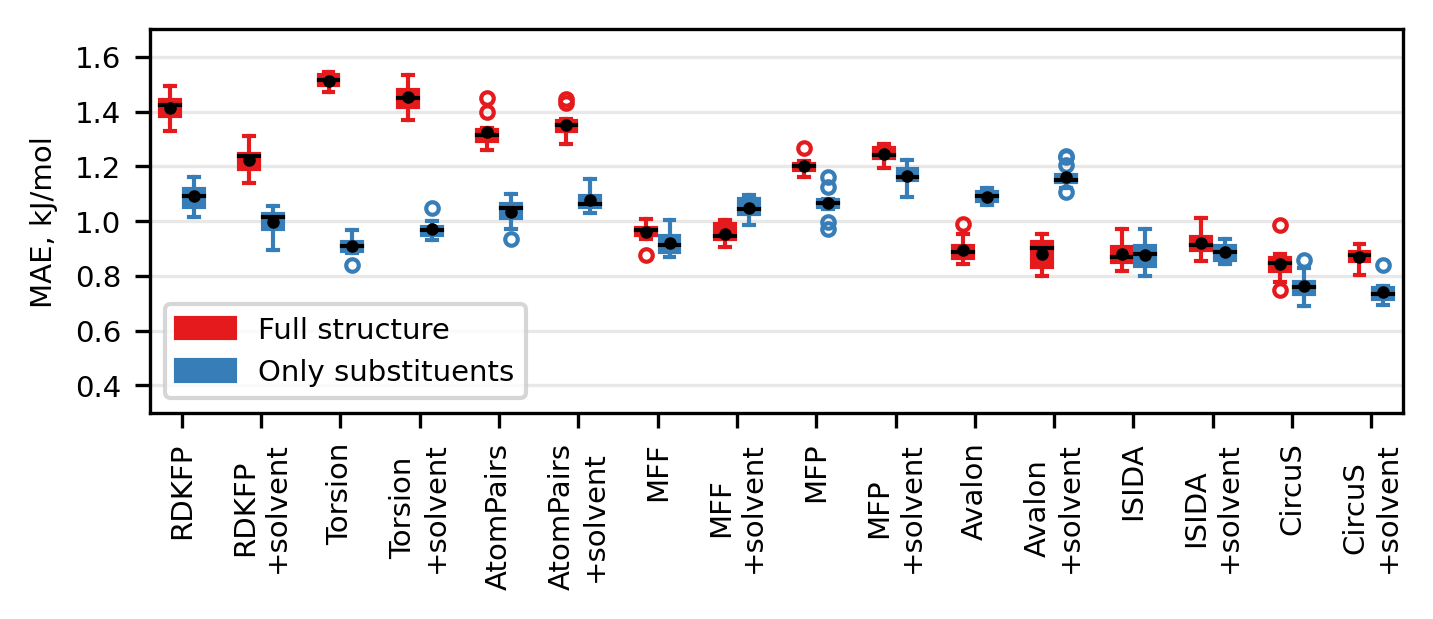

In [19]:
fig, ax = plt.subplots(figsize = (12.4*cm,5.5*cm), dpi=300, facecolor="w")

colors = ["#e41a1c","#377eb8"]

bp1 = plt.boxplot(full_structure_mae[::-1], positions=np.arange(0.2, 0.2+2*len(full_structure_mae), 2),
                  patch_artist=True, showmeans=True)
for median in bp1['medians']:
    median.set(color='k', linewidth=1)
for mean in bp1['means']:
    mean.set(marker='o', markerfacecolor='k', markeredgecolor='k', markersize=2)
for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bp1[item], color=colors[0])
plt.setp(bp1["boxes"], facecolor=colors[0])
plt.setp(bp1["fliers"], markeredgecolor=colors[0], markersize=3)

bp2 = plt.boxplot(substituents_mae[::-1], positions=np.arange(0.8, 0.8+2*len(full_structure_mae), 2),
                  patch_artist=True, showmeans=True)
for median in bp2['medians']:
    median.set(color='k', linewidth=1)
for mean in bp2['means']:
    mean.set(marker='o', markerfacecolor='k', markeredgecolor='k', markersize=2)
for item in ['boxes', 'whiskers', 'fliers', 'caps']:
    plt.setp(bp2[item], color=colors[1])
plt.setp(bp2["boxes"], facecolor=colors[1])
plt.setp(bp2["fliers"], markeredgecolor=colors[1], markersize=3)

ax.set_xticks(np.arange(0.5, 0.5+2*len(full_structure_mae), 2))#[0.5, 2.5, 4.5, 6.5, 8.5, 10.5, 12.5, 14.5, 16.5, 18.5])
ax.set_xticklabels(["CircuS\n+solvent", "CircuS", "ISIDA\n+solvent", "ISIDA", 
                    "Avalon\n+solvent", "Avalon", "MFP\n+solvent", "MFP", 
                    "MFF\n+solvent", "MFF", "AtomPairs\n+solvent", "AtomPairs", 
                    "Torsion\n+solvent", "Torsion", "RDKFP\n+solvent", "RDKFP"][::-1], rotation=90)
ax.set_ylabel("MAE, kJ/mol")#, rotation=0, labelpad=-15, loc="top")
ax.set_ylim([0.3, 1.7])
ax.set_yticks([0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])
ax.grid(color="lightgrey", axis="y", alpha=.5)

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Full structure', 'Only substituents'], 
          fontsize=7, loc="lower left")
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(7)
plt.tight_layout()
plt.show()

### LOO on the best models

RMSE(LOO)=0.986
MAE(LOO)=0.741
R2(LOO)=0.905

Y-scrambling results:
RMSE(LOO)=5.496
MAE(LOO)=4.229
R2(LOO)=-1.939


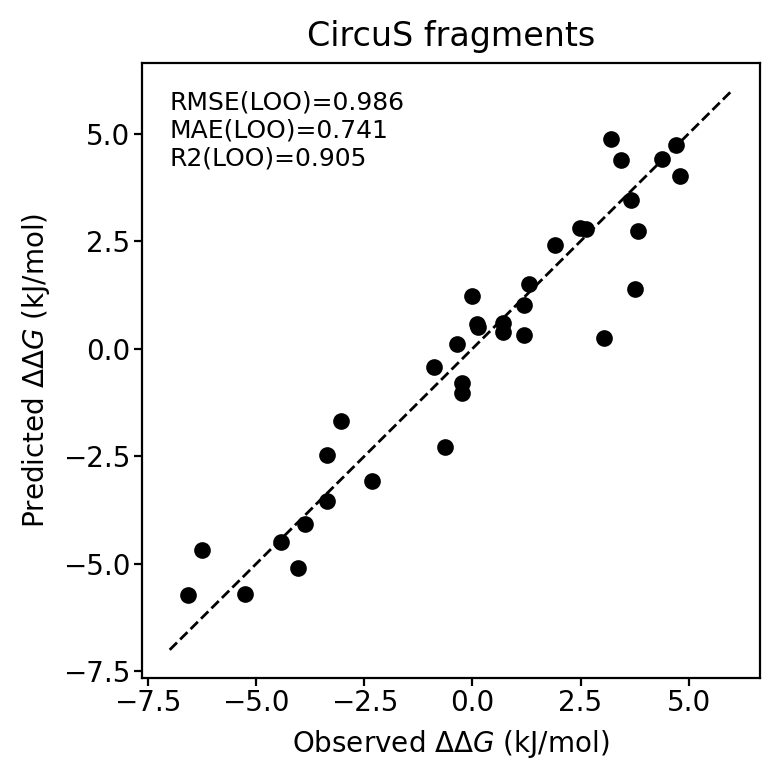

In [23]:
best_model_circus_params = best_model_circus_solv
with open("Benchmark/Benchmark_sub_solvent/"+best_model_circus_params[8]+"/svm.pars") as f:
    best_SVR_circus = libsvm_parser(f.read().strip())

x, y  = load_svmlight_file("Benchmark/Benchmark_sub_solvent/sub-0-4+solvent.scaled.svm")
x = x.toarray()

THF_res_loo_ab = cross_val_predict(best_SVR_circus, x, y, cv=KFold(n_splits=len(y)))
MAE_LOO_circus = np.round(mae(y, THF_res_loo_ab), 3)

fig, ax = plt.subplots(figsize = (4,4), dpi=200, facecolor="w")
a = y
b = THF_res_loo_ab
ax.plot(a, b, "ko", markersize=5)
#ax.plot(ddg_THF, THF_res_loo_ab2, "bo", markersize=5)
ax.plot([-7, 6], [-7, 6], "k--", linewidth=1)
ax.set_xlabel(r"Observed $\Delta\Delta G$ (kJ/mol)")
ax.set_ylabel(r"Predicted $\Delta\Delta G$ (kJ/mol)")

ax.tick_params(length=3, pad=1)
ax.xaxis.set_ticks(np.arange(-7.5, 6, 2.5))
ax.yaxis.set_ticks(np.arange(-7.5, 6, 2.5))
  
textstr = '\n'.join((
    'RMSE(LOO)=%.3f' % (rmse(a,b), ),
    'MAE(LOO)=%.3f' % (mae(a,b), ),
    'R2(LOO)=%.3f' % (r2(a,b), ),))
ax.text(-7, 6, textstr, fontsize=9, 
            horizontalalignment='left', verticalalignment='top',)
plt.title("CircuS fragments")
plt.tight_layout()

textstr = '\n'.join((
    'RMSE(LOO)=%.3f' % (rmse(a,b), ),
    'MAE(LOO)=%.3f' % (mae(a,b), ),
    'R2(LOO)=%.3f' % (r2(a,b), ),))
print(textstr)

# y-scrambling results
x_shuff, y_shuff  = load_svmlight_file("Benchmark/Benchmark_sub_solvent/sub-0-4+solvent.scaled.svm")
x_shuff = x_shuff.toarray()
np.random.shuffle(y_shuff)

THF_res_loo_ab_shuff = cross_val_predict(best_SVR_circus, x_shuff, y_shuff, cv=KFold(n_splits=len(y)))
textstr = '\n'.join(("\nY-scrambling results:",
    'RMSE(LOO)=%.3f' % (rmse(y_shuff,THF_res_loo_ab_shuff), ),
    'MAE(LOO)=%.3f' % (mae(y_shuff,THF_res_loo_ab_shuff), ),
    'R2(LOO)=%.3f' % (r2(y_shuff,THF_res_loo_ab_shuff), ),))
print(textstr)

RMSE(LOO)=1.134
MAE(LOO)=0.850
R2(LOO)=0.875

Y-scrambling results:
RMSE(LOO)=4.771
MAE(LOO)=3.794
R2(LOO)=-1.215


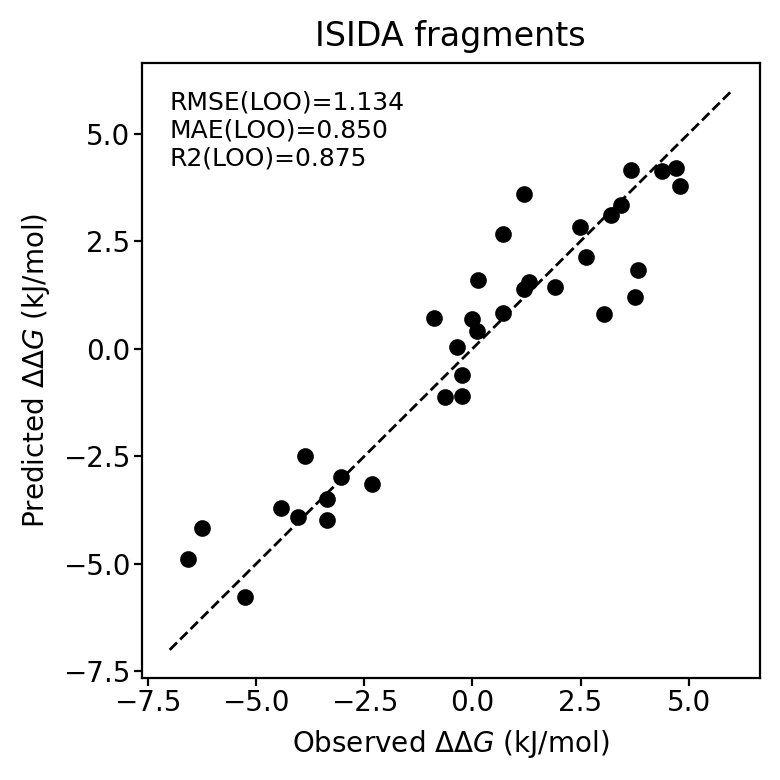

In [21]:
best_model_isida_params = best_model_isida_solv
with open("Benchmark/Benchmark_isida_solvent/"+best_model_isida_params[8]+"/svm.pars") as f:
    best_SVR_isida = libsvm_parser(f.read().strip())

x, y  = load_svmlight_file("Benchmark/Benchmark_isida_solvent/isida3-2-8+solvent.scaled.svm")
x = x.toarray()

THF_res_loo_ab = cross_val_predict(best_SVR_isida, x, y, cv=KFold(n_splits=len(y)))
MAE_LOO_isida = np.round(mae(y, THF_res_loo_ab), 3)

fig, ax = plt.subplots(figsize = (4,4), dpi=200, facecolor="w")
a = y
b = THF_res_loo_ab
ax.plot(a, b, "ko", markersize=5)
#ax.plot(ddg_THF, THF_res_loo_ab2, "bo", markersize=5)
ax.plot([-7, 6], [-7, 6], "k--", linewidth=1)
ax.set_xlabel(r"Observed $\Delta\Delta G$ (kJ/mol)")
ax.set_ylabel(r"Predicted $\Delta\Delta G$ (kJ/mol)")

ax.tick_params(length=3, pad=1)
ax.xaxis.set_ticks(np.arange(-7.5, 6, 2.5))
ax.yaxis.set_ticks(np.arange(-7.5, 6, 2.5))
textstr = '\n'.join((
    'RMSE(LOO)=%.3f' % (rmse(a,b), ),
    'MAE(LOO)=%.3f' % (mae(a,b), ),
    'R2(LOO)=%.3f' % (r2(a,b), ),))
ax.text(-7, 6, textstr, fontsize=9, 
            horizontalalignment='left', verticalalignment='top',)

plt.title("ISIDA fragments")
plt.tight_layout()

textstr = '\n'.join((
    'RMSE(LOO)=%.3f' % (rmse(a,b), ),
    'MAE(LOO)=%.3f' % (mae(a,b), ),
    'R2(LOO)=%.3f' % (r2(a,b), ),))
print(textstr)

# y-scrambling results
x_shuff, y_shuff  = load_svmlight_file("Benchmark/Benchmark_isida_solvent/isida3-2-8+solvent.scaled.svm")
x_shuff = x_shuff.toarray()
np.random.shuffle(y_shuff)

THF_res_loo_ab_shuff = cross_val_predict(best_SVR_isida, x_shuff, y_shuff, cv=KFold(n_splits=len(y)))
textstr = '\n'.join(("\nY-scrambling results:",
    'RMSE(LOO)=%.3f' % (rmse(y_shuff,THF_res_loo_ab_shuff), ),
    'MAE(LOO)=%.3f' % (mae(y_shuff,THF_res_loo_ab_shuff), ),
    'R2(LOO)=%.3f' % (r2(y_shuff,THF_res_loo_ab_shuff), ),))
print(textstr)

RMSE(LOO)=1.142
MAE(LOO)=0.890
R2(LOO)=0.873

Y-scrambling results:
RMSE(LOO)=3.685
MAE(LOO)=3.067
R2(LOO)=-0.321


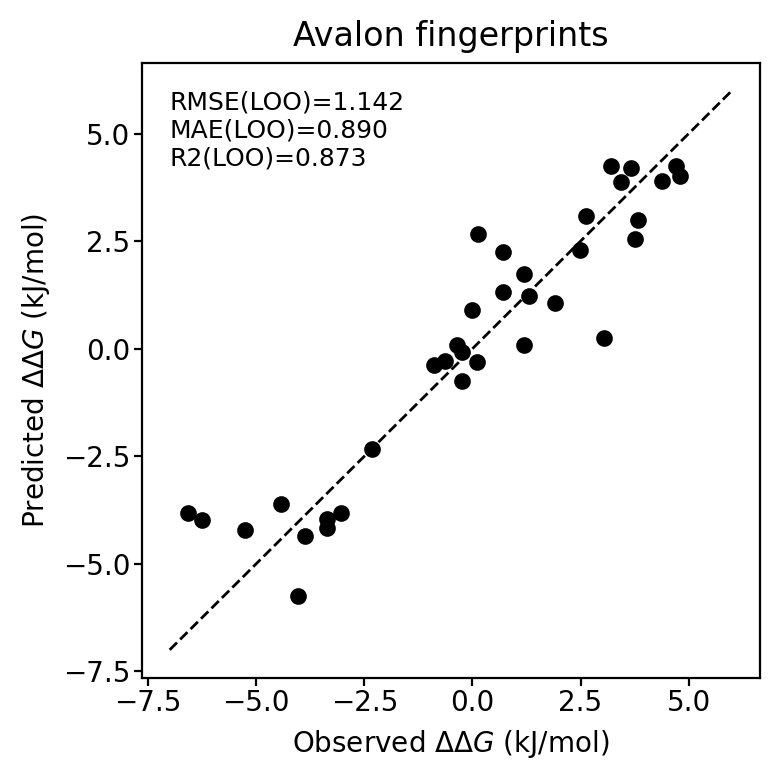

In [24]:
best_model_avalon_params = best_model_avalon_full_solv
with open("Benchmark/Benchmark_avalon_full_solvent/"+best_model_avalon_params[8]+"/svm.pars") as f:
    best_SVR_avalon = libsvm_parser(f.read().strip())
    best_SVR_avalon.set_params(gamma="scale") # for binary descriptors

x, y  = load_svmlight_file("Benchmark/Benchmark_avalon_full_solvent/avalon+solvent.orig.svm")
x = x.toarray()

THF_res_loo_ab = cross_val_predict(best_SVR_avalon, x, y, cv=KFold(n_splits=len(y)))
MAE_LOO_avalon = np.round(mae(y, THF_res_loo_ab), 3)

fig, ax = plt.subplots(figsize = (4,4), dpi=200, facecolor="w")
a = y
b = THF_res_loo_ab
ax.plot(a, b, "ko", markersize=5)
#ax.plot(ddg_THF, THF_res_loo_ab2, "bo", markersize=5)
ax.plot([-7, 6], [-7, 6], "k--", linewidth=1)
ax.set_xlabel(r"Observed $\Delta\Delta G$ (kJ/mol)")
ax.set_ylabel(r"Predicted $\Delta\Delta G$ (kJ/mol)")

ax.tick_params(length=3, pad=1)
ax.xaxis.set_ticks(np.arange(-7.5, 6, 2.5))
ax.yaxis.set_ticks(np.arange(-7.5, 6, 2.5))
textstr = '\n'.join((
    'RMSE(LOO)=%.3f' % (rmse(a,b), ),
    'MAE(LOO)=%.3f' % (mae(a,b), ),
    'R2(LOO)=%.3f' % (r2(a,b), ),))
ax.text(-7, 6, textstr, fontsize=9, 
            horizontalalignment='left', verticalalignment='top',)

plt.title("Avalon fingerprints")
plt.tight_layout()

print(textstr)

# y-scrambling results
x_shuff, y_shuff  = load_svmlight_file("Benchmark/Benchmark_avalon_full_solvent/avalon+solvent.orig.svm")
x_shuff = x_shuff.toarray()
np.random.shuffle(y_shuff)

THF_res_loo_ab_shuff = cross_val_predict(best_SVR_avalon, x_shuff, y_shuff, cv=KFold(n_splits=len(y)))
textstr = '\n'.join(("\nY-scrambling results:",
    'RMSE(LOO)=%.3f' % (rmse(y_shuff,THF_res_loo_ab_shuff), ),
    'MAE(LOO)=%.3f' % (mae(y_shuff,THF_res_loo_ab_shuff), ),
    'R2(LOO)=%.3f' % (r2(y_shuff,THF_res_loo_ab_shuff), ),))
print(textstr)

RMSE(LOO)=1.913
MAE(LOO)=1.409
R2(LOO)=0.644

Y-scrambling results:
RMSE(LOO)=4.338
MAE(LOO)=3.454
R2(LOO)=-0.831


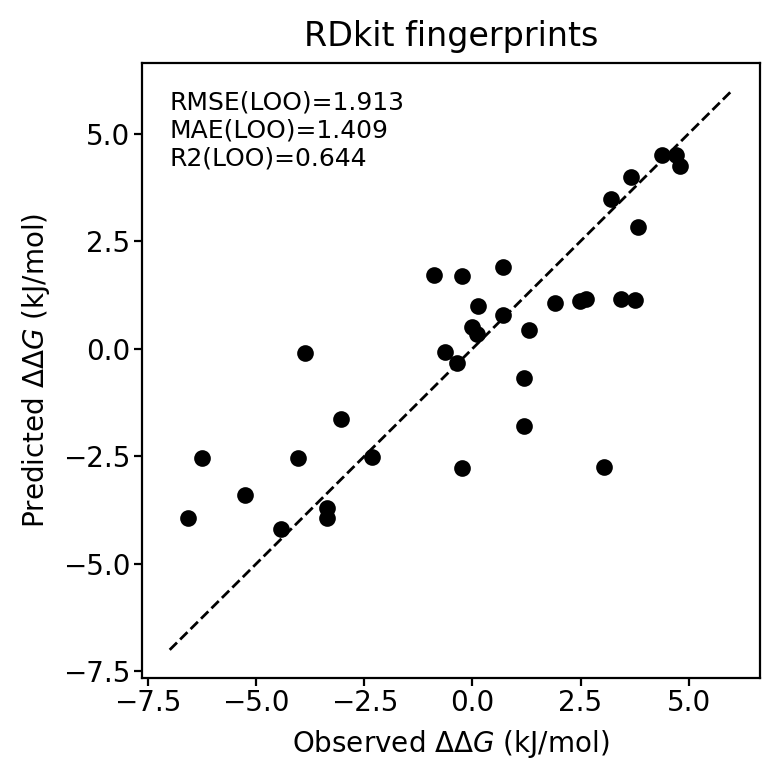

In [25]:
best_model_rdkfp_params = best_model_rdkfp_solv
with open("Benchmark/Benchmark_rdkfp_solvent/"+best_model_rdkfp_params[8]+"/svm.pars") as f:
    best_SVR_rdkfp = libsvm_parser(f.read().strip())
    best_SVR_rdkfp.set_params(gamma="scale") # for binary descriptors

x, y  = load_svmlight_file("Benchmark/Benchmark_rdkfp_solvent/rdkfp+solvent.orig.svm")
x = x.toarray()

THF_res_loo_ab = cross_val_predict(best_SVR_rdkfp, x, y, cv=KFold(n_splits=len(y)))
MAE_LOO_rdkfp = np.round(mae(y, THF_res_loo_ab), 3)

fig, ax = plt.subplots(figsize = (4,4), dpi=200, facecolor="w")
a = y
b = THF_res_loo_ab
ax.plot(a, b, "ko", markersize=5)
#ax.plot(ddg_THF, THF_res_loo_ab2, "bo", markersize=5)
ax.plot([-7, 6], [-7, 6], "k--", linewidth=1)
ax.set_xlabel(r"Observed $\Delta\Delta G$ (kJ/mol)")
ax.set_ylabel(r"Predicted $\Delta\Delta G$ (kJ/mol)")

ax.tick_params(length=3, pad=1)
ax.xaxis.set_ticks(np.arange(-7.5, 6, 2.5))
ax.yaxis.set_ticks(np.arange(-7.5, 6, 2.5))
textstr = '\n'.join((
    'RMSE(LOO)=%.3f' % (rmse(a,b), ),
    'MAE(LOO)=%.3f' % (mae(a,b), ),
    'R2(LOO)=%.3f' % (r2(a,b), ),))
ax.text(-7, 6, textstr, fontsize=9, 
            horizontalalignment='left', verticalalignment='top',)
plt.title("RDkit fingerprints")
plt.tight_layout()


print(textstr)

# y-scrambling results
x_shuff, y_shuff  = load_svmlight_file("Benchmark/Benchmark_rdkfp_solvent/rdkfp+solvent.orig.svm")
x_shuff = x_shuff.toarray()
np.random.shuffle(y_shuff)

THF_res_loo_ab_shuff = cross_val_predict(best_SVR_rdkfp, x_shuff, y_shuff, cv=KFold(n_splits=len(y)))
textstr = '\n'.join(("\nY-scrambling results:",
    'RMSE(LOO)=%.3f' % (rmse(y_shuff,THF_res_loo_ab_shuff), ),
    'MAE(LOO)=%.3f' % (mae(y_shuff,THF_res_loo_ab_shuff), ),
    'R2(LOO)=%.3f' % (r2(y_shuff,THF_res_loo_ab_shuff), ),))
print(textstr)

RMSE(LOO)=1.480
MAE(LOO)=1.074
R2(LOO)=0.787

Y-scrambling results:
RMSE(LOO)=3.796
MAE(LOO)=3.004
R2(LOO)=-0.402


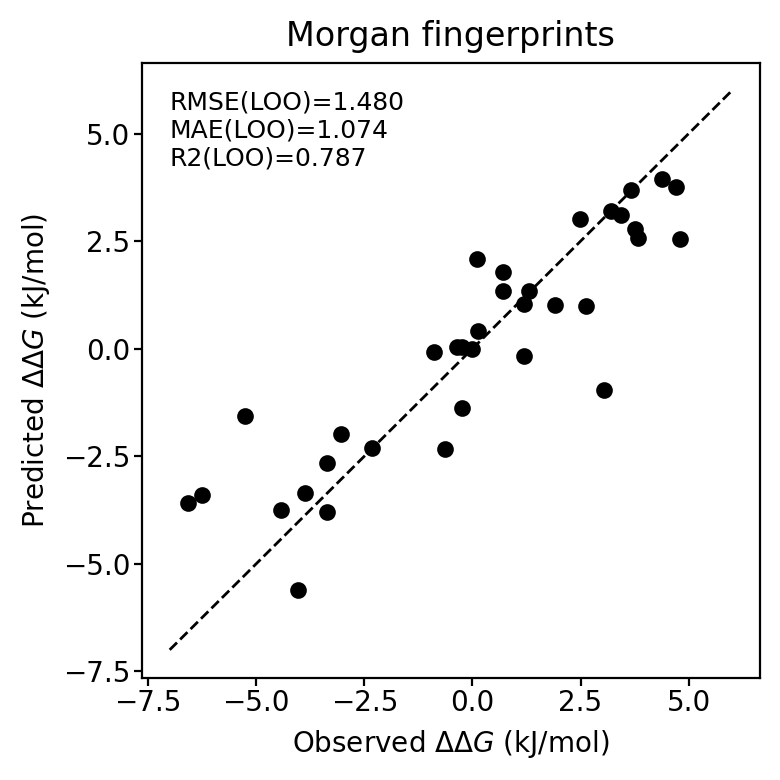

In [26]:
best_model_morgan_params = best_model_mfp
with open("Benchmark/Benchmark_mfp04/"+best_model_morgan_params[8]+"/svm.pars") as f:
    best_SVR_morgan = libsvm_parser(f.read().strip())
    best_SVR_morgan.set_params(gamma="scale") # for binary descriptors

x, y  = load_svmlight_file("Benchmark/Benchmark_mfp04/Ar_MFP_4.scaled.svm")
x = x.toarray()

THF_res_loo_ab = cross_val_predict(best_SVR_morgan, x, y, cv=KFold(n_splits=len(y)))
MAE_LOO_mfp = np.round(mae(y, THF_res_loo_ab), 3)

fig, ax = plt.subplots(figsize = (4,4), dpi=200, facecolor="w")
a = y
b = THF_res_loo_ab
ax.plot(a, b, "ko", markersize=5)
#ax.plot(ddg_THF, THF_res_loo_ab2, "bo", markersize=5)
ax.plot([-7, 6], [-7, 6], "k--", linewidth=1)
ax.set_xlabel(r"Observed $\Delta\Delta G$ (kJ/mol)")
ax.set_ylabel(r"Predicted $\Delta\Delta G$ (kJ/mol)")

ax.tick_params(length=3, pad=1)
ax.xaxis.set_ticks(np.arange(-7.5, 6, 2.5))
ax.yaxis.set_ticks(np.arange(-7.5, 6, 2.5))
textstr = '\n'.join((
    'RMSE(LOO)=%.3f' % (rmse(a,b), ),
    'MAE(LOO)=%.3f' % (mae(a,b), ),
    'R2(LOO)=%.3f' % (r2(a,b), ),))
ax.text(-7, 6, textstr, fontsize=9, 
            horizontalalignment='left', verticalalignment='top',)

plt.title("Morgan fingerprints")
plt.tight_layout()

textstr = '\n'.join((
    'RMSE(LOO)=%.3f' % (rmse(a,b), ),
    'MAE(LOO)=%.3f' % (mae(a,b), ),
    'R2(LOO)=%.3f' % (r2(a,b), ),))
print(textstr)

# y-scrambling results
x_shuff, y_shuff  = load_svmlight_file("Benchmark/Benchmark_mfp04/Ar_MFP_4.scaled.svm")
x_shuff = x_shuff.toarray()
np.random.shuffle(y_shuff)

THF_res_loo_ab_shuff = cross_val_predict(best_SVR_morgan, x_shuff, y_shuff, cv=KFold(n_splits=len(y)))
textstr = '\n'.join(("\nY-scrambling results:",
    'RMSE(LOO)=%.3f' % (rmse(y_shuff,THF_res_loo_ab_shuff), ),
    'MAE(LOO)=%.3f' % (mae(y_shuff,THF_res_loo_ab_shuff), ),
    'R2(LOO)=%.3f' % (r2(y_shuff,THF_res_loo_ab_shuff), ),))
print(textstr)

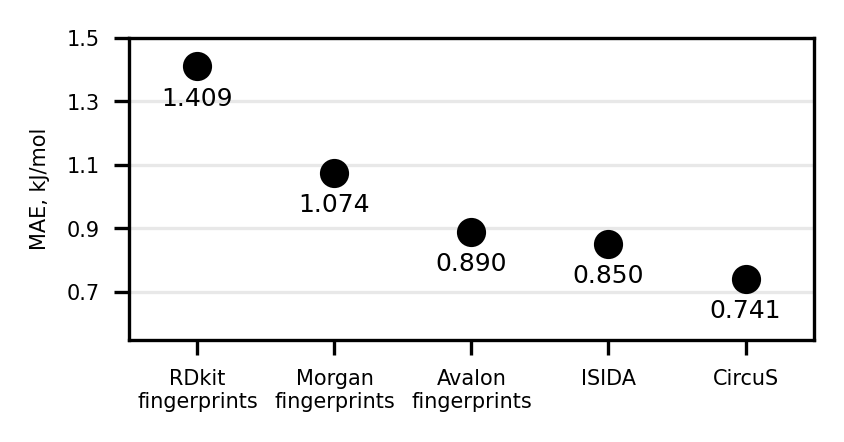

In [27]:
fig, ax = plt.subplots(figsize = (7.4*cm,4*cm), dpi=300, facecolor="w")

colors = ["#e41a1c","#377eb8"]

x = [0.5, 1.5, 2.5, 3.5, 4.5]
loo_res = [MAE_LOO_rdkfp, MAE_LOO_mfp, MAE_LOO_avalon, MAE_LOO_isida, MAE_LOO_circus]

#ax.plot(x, cv_res, "^", color=colors[0], fillstyle='none')
ax.plot(x, loo_res, "ko")
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])

for i in range(5):
    ax.text(x[i], loo_res[i]-0.1, "%.3f" % loo_res[i], fontsize=6, 
            horizontalalignment='center', verticalalignment='center',)
ax.set_xticklabels(["CircuS", "ISIDA", "Avalon\nfingerprints", "Morgan\nfingerprints", "RDkit\nfingerprints"][::-1])
ax.set_ylabel("MAE, kJ/mol")#, rotation=0, labelpad=-15, loc="top")
ax.set_ylim([0.55, 1.5])
ax.set_xlim([0, 5])
ax.set_yticks([ 0.7, 0.9, 1.1, 1.3, 1.5])
ax.grid(color="lightgrey", axis="y", alpha=.5)

#ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Full structure', 'Only substituents'], fontsize=7, loc="lower left")
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(5)
plt.tight_layout()
plt.show()

## Additional statistical tests for benchmark

### One-hot encoding

In [28]:
from sklearn.model_selection import GridSearchCV

Ar_substituents = list(set(data_THF.Ar))
desc_OHE_THF = np.zeros((len(ddg_THF), len(Ar_substituents)), dtype=int)
for i, row in enumerate(data_THF.Ar):
    desc_OHE_THF[i, Ar_substituents.index(row)] = 1

solv_OHE_THF = np.zeros((len(ddg_THF), 2), dtype=int)
for i, row in enumerate(data_THF.solvent):
    if row=="toluene":
        solv_OHE_THF[i, 0] = 1
    else:
        solv_OHE_THF[i, 1] = 1

desc_OHE_THF_solv = np.hstack([desc_OHE_THF, solv_OHE_THF])

In [30]:
# model with solvent

param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], "coef0":[-10,-5,-1,0,1,5,10], "epsilon":[0.1,0.5,1], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], "coef0":[-10,-5,-1,0,1,5,10], "epsilon":[0.1,0.5,1], 'gamma': ["scale", "auto"], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], "coef0":[-10,-5,-1,0,1,5,10], "epsilon":[0.1,0.5,1], 'kernel': ['poly']},
  {'C': [0.1, 1, 10, 100, 1000], "coef0":[-10,-5,-1,0,1,5,10], "epsilon":[0.1,0.5,1], 'gamma': ["scale", "auto"], 'kernel': ['sigmoid']}
 ]
svr = SVR()
gsr = GridSearchCV(svr, param_grid, cv=10)
gsr.fit(desc_OHE_THF_solv, ddg_THF_calib)

OHE_THF_model = gsr.best_estimator_ ## for solv
OHE_THF_cv_results = [cross_val_predict(OHE_THF_model, desc_OHE_THF_solv, 
                                        ddg_THF_calib, cv=KFold(n_splits=10)) for i in range(12)]
OHE_THF_r2 = [r2(ddg_THF_calib, r) for r in OHE_THF_cv_results]
textstr = '\n'.join((
    'RMSE(CV)=%.3f' % (rmse(ddg_THF_calib, np.mean(OHE_THF_cv_results, axis=0)), ),
    'MAE(CV)=%.3f' % (mae(ddg_THF_calib, np.mean(OHE_THF_cv_results, axis=0)), ),
    'R2(CV)=%.3f' % (r2(ddg_THF_calib, np.mean(OHE_THF_cv_results, axis=0)), ),))
print("One-hot encoding model results in 10-fold CV:")
print(textstr)

One-hot encoding model results in 10-fold CV:
RMSE(CV)=2.872
MAE(CV)=2.114
R2(CV)=0.198


In [31]:
# model without solvent

param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], "coef0":[-10,-5,-1,0,1,5,10], "epsilon":[0.1,0.5,1], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], "coef0":[-10,-5,-1,0,1,5,10], "epsilon":[0.1,0.5,1], 'gamma': ["scale", "auto"], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], "coef0":[-10,-5,-1,0,1,5,10], "epsilon":[0.1,0.5,1], 'kernel': ['poly']},
  {'C': [0.1, 1, 10, 100, 1000], "coef0":[-10,-5,-1,0,1,5,10], "epsilon":[0.1,0.5,1], 'gamma': ["scale", "auto"], 'kernel': ['sigmoid']}
 ]
svr = SVR()
gsr = GridSearchCV(svr, param_grid, cv=10)
gsr.fit(desc_OHE_THF, ddg_THF_calib)

OHE_THF_nosolv_model = gsr.best_estimator_ ## for non-solv
OHE_THF_nosolv_cv_results = [cross_val_predict(OHE_THF_nosolv_model, desc_OHE_THF, 
                                               ddg_THF_calib, cv=KFold(n_splits=10)) for i in range(12)]
OHE_THF_nosolv_r2 = [r2(ddg_THF_calib, r) for r in OHE_THF_nosolv_cv_results]
textstr = '\n'.join((
    'RMSE(CV)=%.3f' % (rmse(ddg_THF_calib, np.mean(OHE_THF_nosolv_cv_results, axis=0)), ),
    'MAE(CV)=%.3f' % (mae(ddg_THF_calib, np.mean(OHE_THF_nosolv_cv_results, axis=0)), ),
    'R2(CV)=%.3f' % (r2(ddg_THF_calib, np.mean(OHE_THF_nosolv_cv_results, axis=0)), ),))
print("One-hot encoding model (without solvent) results in 10-fold CV:")
print(textstr)

One-hot encoding model (without solvent) results in 10-fold CV:
RMSE(CV)=3.221
MAE(CV)=2.594
R2(CV)=-0.009


### Random descriptor values

In [33]:
# substituents + solvent
with open("Benchmark/Benchmark_sub_solvent/"+best_model_circus_solv[8]+"/svm.pars") as f:
    rand_circus = libsvm_parser(f.read().strip())

x, y  = load_svmlight_file("Benchmark/Benchmark_sub_solvent/sub-0-4+solvent.orig.svm")
x = x.toarray().flatten()
std = np.std(x)
    
x, y  = load_svmlight_file("Benchmark/Benchmark_sub_solvent/sub-0-4+solvent.scaled.svm")
x = x.toarray()
x = np.abs(np.random.normal(scale=2*std**2, size=x.shape)).astype(int)
x_norm = MinMaxScaler().fit_transform(x)

rand_res = [cross_val_predict(rand_circus, x_norm, y, cv=KFold(n_splits=10)) for i in range(12)]
rand_r2 = [r2(y, r) for r in rand_res]
print("Random variables model (substituents and solvents) results in 10-fold CV:")
textstr = '\n'.join((
    'RMSE(CV)=%.3f' % (rmse(y, np.mean(rand_res, axis=0)), ),
    'MAE(CV)=%.3f' % (mae(y, np.mean(rand_res, axis=0)), ),
    'R2(CV)=%.3f' % (r2(y, np.mean(rand_res, axis=0)), ),))
print(textstr)

Random variables model (substituents and solvents) results in 10-fold CV:
RMSE(CV)=4.275
MAE(CV)=3.534
R2(CV)=-0.778


In [34]:
# substituents 
with open("Benchmark/Benchmark_sub/"+best_model_circus[8]+"/svm.pars") as f:
    rand_circus = libsvm_parser(f.read().strip())

x, y  = load_svmlight_file("Benchmark/Benchmark_sub/sub-0-4.orig.svm")
x = x.toarray().flatten()
std = np.std(x)
    
x, y  = load_svmlight_file("Benchmark/Benchmark_sub/sub-0-4.scaled.svm")
x = x.toarray()
x = np.abs(np.random.normal(scale=2*std**2, size=x.shape)).astype(int)
x_norm = MinMaxScaler().fit_transform(x)

rand_res = [cross_val_predict(rand_circus, x_norm, y, cv=KFold(n_splits=10)) for i in range(12)]
rand_r2 = [r2(y, r) for r in rand_res]
print("Random variables model (substituents, without solvents) results in 10-fold CV:")
textstr = '\n'.join((
    'RMSE(CV)=%.3f' % (rmse(y, np.mean(rand_res, axis=0)), ),
    'MAE(CV)=%.3f' % (mae(y, np.mean(rand_res, axis=0)), ),
    'R2(CV)=%.3f' % (r2(y, np.mean(rand_res, axis=0)), ),))
print(textstr)

Random variables model (substituents, without solvents) results in 10-fold CV:
RMSE(CV)=2.897
MAE(CV)=2.397
R2(CV)=0.183


In [35]:
# full structure
with open("Benchmark/Benchmark_sub_full/"+best_model_circus_full[8]+"/svm.pars") as f:
    rand_circus = libsvm_parser(f.read().strip())

x, y  = load_svmlight_file("Benchmark/Benchmark_sub_full/sub-0-4.orig.svm")
x = x.toarray().flatten()
std = np.std(x)
    
x, y  = load_svmlight_file("Benchmark/Benchmark_sub_full/sub-0-4.scaled.svm")
x = x.toarray()
x = np.abs(np.random.normal(scale=2*std**2, size=x.shape)).astype(int)
x_norm = MinMaxScaler().fit_transform(x)

rand_res = [cross_val_predict(rand_circus, x_norm, y, cv=KFold(n_splits=10)) for i in range(12)]
rand_r2 = [r2(y, r) for r in rand_res]
print("Random variables model (full structure, without solvents) results in 10-fold CV:")
textstr = '\n'.join((
    'RMSE(CV)=%.3f' % (rmse(y, np.mean(rand_res, axis=0)), ),
    'MAE(CV)=%.3f' % (mae(y, np.mean(rand_res, axis=0)), ),
    'R2(CV)=%.3f' % (r2(y, np.mean(rand_res, axis=0)), ),))
print(textstr)

Random variables model (full structure, without solvents) results in 10-fold CV:
RMSE(CV)=3.749
MAE(CV)=3.087
R2(CV)=-0.368


In [36]:
# full structure + solvent
with open("Benchmark/Benchmark_sub_full_solvent/"+best_model_circus_full_solv[8]+"/svm.pars") as f:
    rand_circus = libsvm_parser(f.read().strip())

x, y  = load_svmlight_file("Benchmark/Benchmark_sub_full_solvent/sub-0-4+solvent.orig.svm")
x = x.toarray().flatten()
std = np.std(x)
    
x, y  = load_svmlight_file("Benchmark/Benchmark_sub_full_solvent/sub-0-4+solvent.scaled.svm")
x = x.toarray()
x = np.abs(np.random.normal(scale=2*std**2, size=x.shape)).astype(int)
x_norm = MinMaxScaler().fit_transform(x)

rand_res = [cross_val_predict(rand_circus, x_norm, y, cv=KFold(n_splits=10)) for i in range(12)]
rand_r2 = [r2(y, r) for r in rand_res]
print("Random variables model (full structure and solvents) results in 10-fold CV:")
textstr = '\n'.join((
    'RMSE(CV)=%.3f' % (rmse(y, np.mean(rand_res, axis=0)), ),
    'MAE(CV)=%.3f' % (mae(y, np.mean(rand_res, axis=0)), ),
    'R2(CV)=%.3f' % (r2(y, np.mean(rand_res, axis=0)), ),))
print(textstr)

Random variables model (full structure and solvents) results in 10-fold CV:
RMSE(CV)=3.532
MAE(CV)=2.890
R2(CV)=-0.214


## Building full model on THF + THP

In [38]:
ddg_THP_train_calib = calibrate(ddg_THP_train, data_THP_train.concentration, 0.05, cyh_calib_coef,
                                data_THP_train["T(K)"], calib_function)
ddg_THP_train_calib = np.round(ddg_THP_train_calib, 4)
ddg_full_train = np.concatenate([ddg_THF_calib, ddg_THP_train_calib])
data_full_train = pd.concat([data_THF, data_THP_train])

In [ ]:
# Descriptors generation
# DO NOT RELAUNCH unless new optimization is needed!!!!!

# desc_names = []
# for k in [6,9]:
#     for i in range(3,6):
#         desc_names.append("isida"+str(k)+"-1-"+str(i))
        
# for k in [3]:
#     for i in range(5,9):
#         desc_names.append("isida"+str(k)+"-2-"+str(i))

# for i in range(2,5):
#     desc_names.append("sub-0-"+str(i))  

# for s in [data_full_train["solvent"]]:
#     for c in ["mol_Ar"]:
#         for d in desc_names:
#             n = d
#             if d.startswith("isida"):
#                 fr_type = int(d[5:].split("-")[-3])
#                 fr_lower = int(d.split("-")[-2])
#                 fr_upper = int(d.split("-")[-1])
#                 df = ComplexFragmentor(associator={"mol_Ar":Fragmentor(fragment_type=fr_type,min_length=fr_lower, max_length=fr_upper),
#                                                    "mol_R":Fragmentor(fragment_type=3,min_length=2, max_length=4),
#                                                    "CGR":Fragmentor(fragment_type=3,min_length=2, max_length=4)},
#                                        structure_columns=["mol_Ar", "mol_R", "CGR"])
#                 frags_train = df.fit_transform(data_full_train)
#             elif d.startswith("sub"):
#                 fr_lower = int(d[3:].split("-")[-2])
#                 fr_upper = int(d[3:].split("-")[-1])
#                 df = ComplexFragmentor(associator={"mol_Ar":Augmentor(lower=fr_lower, upper=fr_upper),
#                                                    "mol_R":Augmentor(lower=0, upper=2),
#                                                    "CGR":Augmentor(lower=0, upper=2)},
#                                        structure_columns=["mol_Ar", "mol_R", "CGR"])
#                 frags_train = df.fit_transform(data_full_train)
            
#             s_folder = ""
#             if len(s):
#                 frags_train = pd.concat([frags_train, 
#                                          solvent.SolventVectorizer().fit_transform(s)], axis=1, sort=False)
#                 s_folder = "_solvent"
#                 n = n + "+solvent"

#             if d.startswith("isida"):
#                 dump_svmlight_file(frags_train, ddg_full_train, 
#                                    "Descriptors_THF+THP/isida"+s_folder+"/"+n+".svm", zero_based=False)
#                 np.savetxt("Descriptors_THF+THP/isida"+s_folder+"/ref.SVMreg", ddg_full_train, fmt="%g")
#             elif d.startswith("sub"):
#                 dump_svmlight_file(frags_train, ddg_full_train, 
#                                    "Descriptors_THF+THP/sub"+s_folder+"/"+n+".svm", zero_based=False)
#                 np.savetxt("Descriptors_THF+THP/sub"+s_folder+"/ref.SVMreg", ddg_full_train, fmt="%g")
          

In [40]:
full_model_params = pd.read_table("Final_model/best_pop", header=None, delimiter=" ").iloc[0]
with open("Final_model/"+full_model_params[8]+"/svm.pars") as f:
    best_model_full = Pipeline([("fragmentor",ComplexFragmentor(associator={"mol_Ar":Augmentor(lower=0, upper=4),
                                                   "mol_R":Augmentor(lower=0, upper=2),
                                                   "CGR":Augmentor(lower=0, upper=2),
                                                   "solvent":solvent.SolventVectorizer()},
                                       structure_columns=["mol_Ar", "mol_R", "CGR"])),
          ("pruner",Pruner("Final_model/"+full_model_params[0]+".pri", scaling=full_model_params[1]=="scaled")),
          ("model",libsvm_parser(f.read().strip()))])

In [41]:
best_model_full.fit(data_full_train, ddg_full_train)

Pipeline(steps=[('fragmentor',
                 ComplexFragmentor(associator={'CGR': Augmentor(upper=2),
                                               'mol_Ar': Augmentor(upper=4),
                                               'mol_R': Augmentor(upper=2),
                                               'solvent': SolventVectorizer()},
                                   structure_columns=['mol_Ar', 'mol_R',
                                                      'CGR'])),
                ('pruner', Pruner(prifile='Final_model/sub-0-4+solvent.pri')),
                ('model',
                 SVR(C=445.8578, coef0=-8.4, epsilon=0.965829, gamma='auto'))])

RMSE(CV)=1.221
MAE(CV)=0.987
R2(CV)=0.856


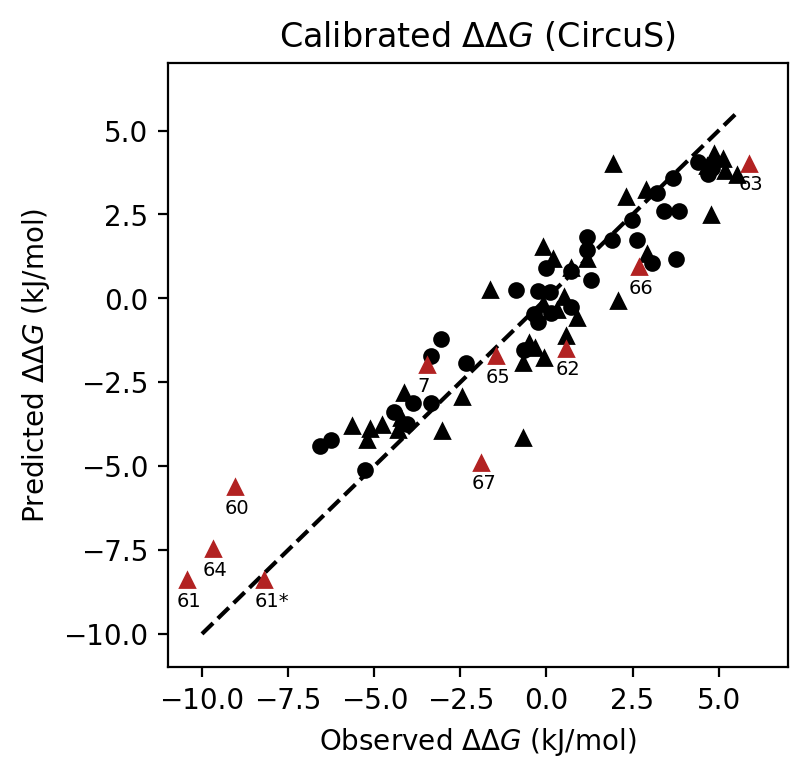

RMSE(CV)=0.936
MAE(CV)=0.754
R2(CV)=0.878


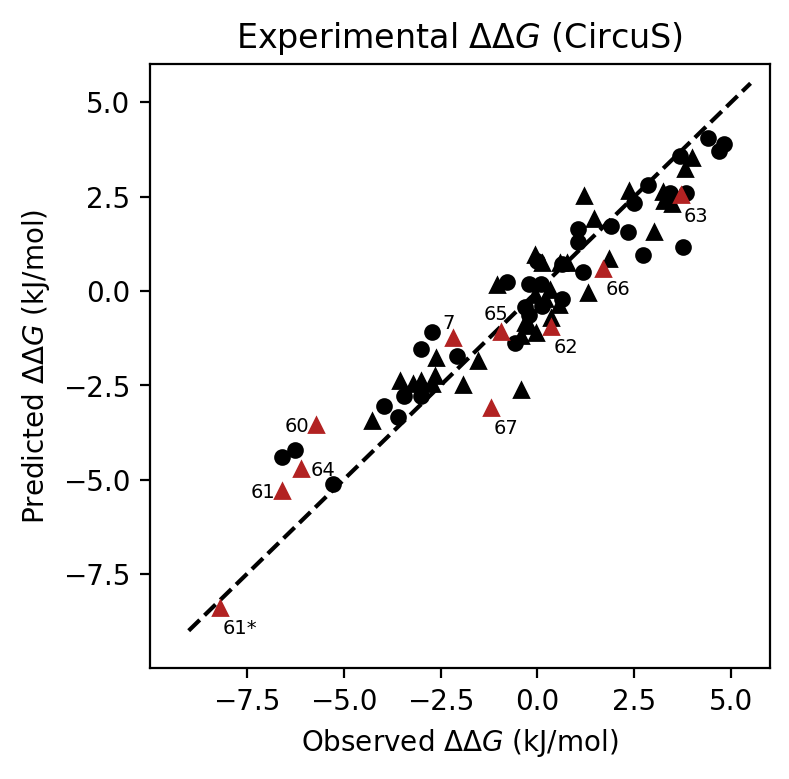

In [46]:
full_model_cv_results = np.loadtxt("Final_model/"+full_model_params[8]+"/final_test.pred.gz")

x = ddg_full_train
y = np.mean(full_model_cv_results[:,2:], axis=1)

fig, ax = plt.subplots(figsize=(4,4), dpi=200, facecolor="white")

plt.plot(x[:35], y[:35], "ko", markersize=5)
plt.plot(x[35:], y[35:], "k^", markersize=5)
plt.plot([-10, 5.5], [-10, 5.5], "k--", label="_nolegend_")
plt.xticks(np.arange(-10,6))

test_preds = best_model_full.predict(data_THP_test)

textstr = '\n'.join((
    'RMSE(CV)=%.3f' % (rmse(x, y), ),
    'MAE(CV)=%.3f' % (mae(x, y), ),
    'R2(CV)=%.3f' % (r2(x, y), ),))
print(textstr)

plt.plot(calibrate(ddg_THP_test,  data_THP_test["concentration"], 0.05,
                   cyh_calib_coef, data_THP_test["T(K)"], calib_function), 
                   test_preds, "^", color="firebrick", markersize=5)
for i, row in data_THP_test.iterrows():
    if i==len(data_THP_test)-1:
        plt.annotate(str(row['name'])+'*', (calibrate(ddg_THP_test[i],  data_THP_test.iloc[i]["concentration"], 0.05,
                   cyh_calib_coef, data_THP_test.iloc[i]["T(K)"], calib_function), 
                   test_preds[i]), xytext=(-3.5, -9.5), textcoords="offset points", fontsize=7)
    else:
        plt.annotate(row['name'], (calibrate(ddg_THP_test[i],  data_THP_test.iloc[i]["concentration"], 0.05,
                   cyh_calib_coef, data_THP_test.iloc[i]["T(K)"], calib_function), 
                   test_preds[i]), xytext=(-3.5, -9.5), textcoords="offset points", fontsize=7)

plt.title(r"Calibrated $\Delta \Delta G$ (CircuS)")
plt.ylabel(r"Predicted $\Delta \Delta G$ (kJ/mol)")
plt.xlabel(r"Observed $\Delta \Delta G$ (kJ/mol)")
plt.xlim([-11, 7])
plt.ylim([-11, 7])
plt.xticks(np.arange(-10,7))
plt.yticks(np.arange(-10,7))
#plt.grid(color="lightgrey")
plt.xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5])
plt.yticks([-10, -7.5, -5, -2.5, 0, 2.5, 5])
plt.show()

THF_tol_ind = data_THF[data_THF.solvent == "toluene"].index
THF_cyh_ind = data_THF[data_THF.solvent == "cyclohexane"].index

y_THF_tol_decalib = calibrate(y[THF_tol_ind], 0.05, data_THF.iloc[THF_tol_ind]["concentration"], 
                              tol_calib_coef, data_THF.iloc[THF_tol_ind]["T(K)"], calib_function)

y_THF_cyh_decalib = calibrate(y[THF_cyh_ind], 0.05, data_THF.iloc[THF_cyh_ind]["concentration"], 
                              cyh_calib_coef, data_THF.iloc[THF_cyh_ind]["T(K)"], calib_function)

y_THP_decalib = calibrate(y[35:], 0.05, data_THP_train["concentration"], cyh_calib_coef, 
                          data_THP_train["T(K)"], calib_function)

fig, ax = plt.subplots(figsize=(4,4), dpi=200, facecolor="white")

plt.plot(ddg_THF[THF_tol_ind], y_THF_tol_decalib, "ko", markersize=5)
plt.plot(ddg_THF[THF_cyh_ind], y_THF_cyh_decalib, "ko", markersize=5)
plt.plot(ddg_THP_train, y_THP_decalib, "k^", markersize=5)
plt.plot([-9, 5.5], [-9, 5.5], "k--", label="_nolegend_")

test_preds = best_model_full.predict(data_THP_test)

plt.plot(ddg_THP_test, calibrate(test_preds, 0.05, data_THP_test.concentration, cyh_calib_coef, 
                                 data_THP_test["T(K)"], calib_function), 
         "^", color="firebrick", markersize=5)

for i, row in data_THP_test.iterrows():
    if i==len(data_THP_test)-1:
        plt.annotate(str(row['name'])+'*', (ddg_THP_test[i], 
                                            calibrate(test_preds[i], 0.05, data_THP_test.iloc[i].concentration, 
                                            cyh_calib_coef, data_THP_test.iloc[i]["T(K)"], calib_function)), 
                                            xytext=(1, -9.5), textcoords="offset points", fontsize=7)
    elif row['name'] in [67, 62, 66, 63]:
        plt.annotate(str(row['name']), (ddg_THP_test[i], 
                                            calibrate(test_preds[i], 0.05, data_THP_test.iloc[i].concentration, 
                                            cyh_calib_coef, data_THP_test.iloc[i]["T(K)"], calib_function)), 
                                            xytext=(1, -9.5), textcoords="offset points", fontsize=7)
    elif row['name'] in [60,61]:
        plt.annotate(str(row['name']), (ddg_THP_test[i], 
                                            calibrate(test_preds[i], 0.05, data_THP_test.iloc[i].concentration, 
                                            cyh_calib_coef, data_THP_test.iloc[i]["T(K)"], calib_function)), 
                                            xytext=(-11.5, -2.5), textcoords="offset points", fontsize=7)
    elif row['name'] in [64]:
        plt.annotate(str(row['name']), (ddg_THP_test[i], 
                                            calibrate(test_preds[i], 0.05, data_THP_test.iloc[i].concentration, 
                                            cyh_calib_coef, data_THP_test.iloc[i]["T(K)"], calib_function)), 
                                            xytext=(3.5, -2.5), textcoords="offset points", fontsize=7)
    elif row['name'] in [65]:
        plt.annotate(str(row['name']), (ddg_THP_test[i], 
                                            calibrate(test_preds[i], 0.05, data_THP_test.iloc[i].concentration, 
                                            cyh_calib_coef, data_THP_test.iloc[i]["T(K)"], calib_function)), 
                                            xytext=(-6.5, 4.5), textcoords="offset points", fontsize=7)
    else:
        plt.annotate(row['name'], (ddg_THP_test[i], 
                                            calibrate(test_preds[i], 0.05, data_THP_test.iloc[i].concentration, 
                                            cyh_calib_coef, data_THP_test.iloc[i]["T(K)"], calib_function)), 
                                            xytext=(-3.5, 3.5), textcoords="offset points", fontsize=7)

plt.xlim([-10, 6])
plt.ylim([-10, 6])
plt.xticks([-7.5, -5, -2.5, 0, 2.5, 5])
plt.yticks([-7.5, -5, -2.5, 0, 2.5, 5])
#plt.grid(color="lightgrey")
plt.title(r"Experimental $\Delta \Delta G$ (CircuS)")
plt.ylabel(r"Predicted $\Delta \Delta G$ (kJ/mol)")
plt.xlabel(r"Observed $\Delta \Delta G$ (kJ/mol)")

x = np.concatenate([ddg_THF[THF_tol_ind], ddg_THF[THF_cyh_ind], ddg_THP_train])
y_decalib = np.concatenate([y_THF_tol_decalib, y_THF_cyh_decalib, y_THP_decalib])

textstr = '\n'.join((
    'RMSE(CV)=%.3f' % (rmse(x, y_decalib), ),
    'MAE(CV)=%.3f' % (mae(x, y_decalib), ),
    'R2(CV)=%.3f' % (r2(x, y_decalib), ),))
print(textstr)

In [47]:
test_preds_decalib = calibrate(test_preds, 0.05, data_THP_test.concentration, cyh_calib_coef, 
                                 data_THP_test["T(K)"], calib_function)
er = np.array(ddg2fraction(test_preds_decalib, data_THP_test["T(K)"]))
print("\t".join(["ddG_calib", "ddG_decalib", "fr(R)", "e.r."]))
for i in range(len(test_preds_decalib)):
    print("\t".join([str(ddg_THP_test[i]), str(np.round(test_preds_decalib[i], 3)),
          str(np.round(er[i], 3)), str(np.round(er[i], 2))+":"+str(np.round(100-er[i], 2))]))

ddG_calib	ddG_decalib	fr(R)	e.r.
-2.1904	-1.259	38.833	38.83:61.17
-5.7074	-3.548	21.74	21.74:78.26
-6.5822	-5.291	12.898	12.9:87.1
0.355	-0.948	41.529	41.53:58.47
3.7035	2.531	71.377	71.38:28.62
-6.1091	-4.717	15.411	15.41:84.59
-0.9282	-1.092	40.272	40.27:59.73
1.6904	0.585	55.262	55.26:44.74
-1.1925	-3.091	24.675	24.68:75.32
-8.2	-8.392	4.215	4.21:95.79


## Other models
### Sterimol

In [66]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdmolfiles import MolToXYZFile

conformers = []

for i, m in enumerate(data_THF["Ar"]):
    mol = Chem.MolFromSmiles(str(m))
    m2=Chem.AddHs(mol)
    AllChem.EmbedMolecule(m2)
    AllChem.MMFFOptimizeMolecule(m2)
    conformers.append(m2)
    if len(str(i+1))==1:
        n = "0" + str(i+1)
    else:
        n = str(i+1)
    MolToXYZFile(m2, "THF_xyz/" + n +".xyz")

In [67]:
import dbstep.Dbstep as db

sterimol = []

for j, n in enumerate(["0" + str(i+1) for i in range(9)]+[str(i+1) for i in range(9,35)]):
    mol = db.dbstep("THF_xyz/" + n +".xyz",
                    atom1=2,atom2=1,commandline=True,
                    sterimol=True,measure='classic')
    sterimol.append([mol.L, mol.Bmin, mol.Bmax])
    
steri_solv = np.hstack([sterimol, solvent.SolventVectorizer().fit_transform(data_THF['solvent'])])

   THF_xyz/01.xyz / Bmin:  1.71 / Bmax:  3.24 / L:  4.97
   THF_xyz/02.xyz / Bmin:  1.71 / Bmax:  4.43 / L:  4.97
   THF_xyz/03.xyz / Bmin:  1.71 / Bmax:  3.25 / L:  6.00
   THF_xyz/04.xyz / Bmin:  1.70 / Bmax:  5.72 / L:  5.13
   THF_xyz/05.xyz / Bmin:  1.70 / Bmax:  5.72 / L:  5.13
   THF_xyz/06.xyz / Bmin:  2.02 / Bmax:  7.15 / L:  3.89
   THF_xyz/07.xyz / Bmin:  1.71 / Bmax:  4.47 / L:  7.08
   THF_xyz/08.xyz / Bmin:  1.95 / Bmax:  5.71 / L:  6.00
   THF_xyz/09.xyz / Bmin:  2.16 / Bmax:  5.83 / L:  5.62
   THF_xyz/10.xyz / Bmin:  1.99 / Bmax:  5.73 / L:  6.15
   THF_xyz/11.xyz / Bmin:  2.61 / Bmax:  3.47 / L:  9.23
   THF_xyz/12.xyz / Bmin:  2.84 / Bmax:  3.31 / L:  7.21
   THF_xyz/13.xyz / Bmin:  2.84 / Bmax:  3.31 / L:  7.21
   THF_xyz/14.xyz / Bmin:  2.01 / Bmax:  8.25 / L:  5.14
   THF_xyz/15.xyz / Bmin:  2.89 / Bmax:  4.35 / L:  8.57
   THF_xyz/16.xyz / Bmin:  2.02 / Bmax:  7.08 / L:  5.74
   THF_xyz/17.xyz / Bmin:  1.71 / Bmax:  4.56 / L:  9.29
   THF_xyz/18.xyz / Bmin:  1.79

RMSE(LOO)=2.473
MAE(LOO)=2.018
R2(LOO)=0.405


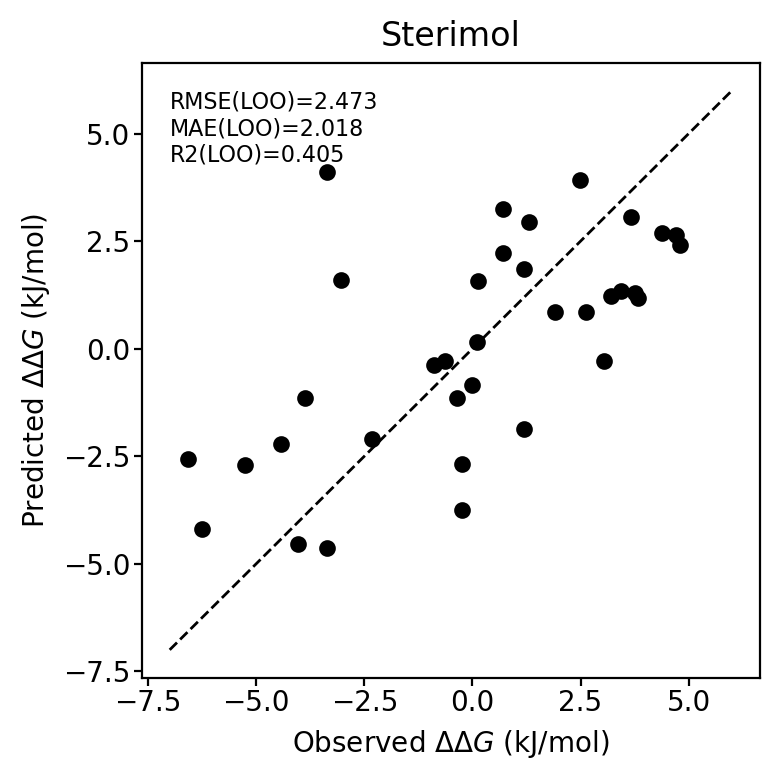

In [69]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
res = cross_val_predict(lr, sterimol, ddg_THF_calib, cv=KFold(len(ddg_THF_calib)))

fig, ax = plt.subplots(figsize = (4,4), dpi=200, facecolor="w")
a = ddg_THF_calib
b = res
ax.plot(a, b, "ko", markersize=5)
#ax.plot(ddg_THF, THF_res_loo_ab2, "bo", markersize=5)
ax.plot([-7, 6], [-7, 6], "k--", linewidth=1)
ax.set_xlabel(r"Observed $\Delta\Delta G$ (kJ/mol)")
ax.set_ylabel(r"Predicted $\Delta\Delta G$ (kJ/mol)")

props = dict(boxstyle='round', facecolor='white', alpha=0.)
ax.tick_params(length=3, pad=1)
ax.xaxis.set_ticks(np.arange(-7.5, 6, 2.5))
ax.yaxis.set_ticks(np.arange(-7.5, 6, 2.5))
textstr = '\n'.join((
    'RMSE(LOO)=%.3f' % (rmse(a,b), ),
    'MAE(LOO)=%.3f' % (mae(a,b), ),
    'R2(LOO)=%.3f' % (r2(a,b), ),))
ax.text(-7, 6, textstr, fontsize=8, 
            horizontalalignment='left', verticalalignment='top',)
plt.title("Sterimol")
plt.tight_layout()

textstr = '\n'.join((
    'RMSE(LOO)=%.3f' % (rmse(a,b), ),
    'MAE(LOO)=%.3f' % (mae(a,b), ),
    'R2(LOO)=%.3f' % (r2(a,b), ),))
print(textstr)

### XGBoost models

In [259]:
import xgboost as xgb

x, y  = load_svmlight_file("Benchmark/Benchmark_sub_solvent/sub-0-4+solvent.scaled.svm")
x = x.toarray()

param_grid = {'n_estimators': [5,10,15,20,25], "eta":[0.001, 0.01, 0.1, 0.3, 0.5, 1], 
              "max_depth":[5,6,7], 'colsample_bytree': [0.3,0.5,0.8,1],
              "subsample":[0.5,0.8,1], 'lambda':[0.1,1,10]}
svr = xgb.XGBRegressor()
gsr = GridSearchCV(svr, param_grid, cv=10)
gsr.fit(x, y)

print(gsr.best_params_)
print(gsr.best_score_)


{'colsample_bytree': 0.8, 'eta': 0.5, 'lambda': 0.1, 'max_depth': 5, 'n_estimators': 25, 'subsample': 0.5}
0.197145529957357


In [260]:
xgb_model = gsr.best_estimator_
THF_res_loo_ab = cross_val_predict(xgb_model, x, y, cv=KFold(n_splits=len(y)))

textstr = '\n'.join((
    'RMSE(LOO)=%.3f' % (rmse(y,THF_res_loo_ab), ),
    'MAE(LOO)=%.3f' % (mae(y,THF_res_loo_ab), ),
    'R2(LOO)=%.3f' % (r2(y,THF_res_loo_ab), ),))
print(textstr)

RMSE(LOO)=1.598
MAE(LOO)=1.191
R2(LOO)=0.752


In [381]:
x, y  = load_svmlight_file("Final_model/sub-0-4+solvent.scaled.svm")
x = x.toarray()

param_grid = {'n_estimators': [5,10,15,20,25], "eta":[0.001, 0.01, 0.1, 0.3, 0.5, 1], 
              "max_depth":[5,6,7], 'colsample_bytree': [0.3,0.5,0.8,1],
              "subsample":[0.5,0.8,1], 'lambda':[0.1,1,10]}
svr = xgb.XGBRegressor()
gsr = GridSearchCV(svr, param_grid, cv=10)
gsr.fit(x, y)

print(gsr.best_params_)
print(gsr.best_score_)



{'colsample_bytree': 0.3, 'eta': 0.5, 'lambda': 1, 'max_depth': 5, 'n_estimators': 15, 'subsample': 0.8}
0.8368221098448434


(70, 274)
RMSE(LOO)=1.079
MAE(LOO)=0.798
R2(LOO)=0.888
-2.1904	-1.4	-1.259	37.623	37.62:62.38
-5.7074	-2.94	-3.548	25.706	25.71:74.29
-6.5822	-3.74	-5.291	20.585	20.58:79.42
0.355	-0.136	-0.948	48.77	48.77:51.23
3.7035	3.167	2.531	75.828	75.83:24.17
-6.1091	-3.149	-4.717	24.293	24.29:75.71
-0.9282	-0.081	-1.092	49.267	49.27:50.73


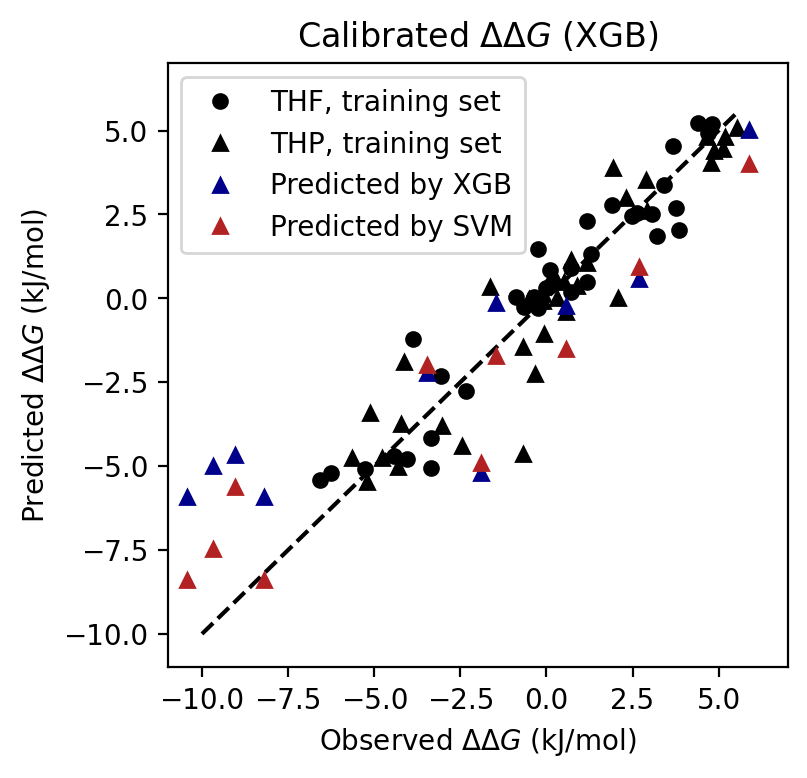

In [384]:
best_xgbmodel_full = gsr.best_estimator_

x, y  = load_svmlight_file("Final_model/sub-0-4+solvent.scaled.svm")
x = x.toarray()
print(x.shape)
THF_res_loo_ab = [cross_val_predict(best_xgbmodel_full, x, y, cv=KFold(n_splits=10)) for i in range(12)]

textstr = '\n'.join((
    'RMSE(10CV)=%.3f' % (rmse(y,np.mean(THF_res_loo_ab, axis=0)), ),
    'MAE(10CV)=%.3f' % (mae(y,np.mean(THF_res_loo_ab, axis=0)), ),
    'R2(10CV)=%.3f' % (r2(y,np.mean(THF_res_loo_ab, axis=0)), ),))
print(textstr)

best_xgbmodel_full.fit(x, y)
test_descs = best_model_full[:2].transform(data_THP_test)
xgb_test_preds = best_xgbmodel_full.predict(test_descs)

xgb_test_preds_decalib = calibrate(xgb_test_preds, 0.05, data_THP_test.concentration, cyh_calib_coef, 
                                 data_THP_test["T(K)"], calib_function)
er = np.array(ddg2fraction(xgb_test_preds_decalib, data_THP_test["T(K)"]))
    
for i in range(7):
    print("\t".join([str(ddg_THP_test[i]), str(np.round(xgb_test_preds_decalib[i], 3)), 
                     str(np.round(test_preds_decalib[i], 3)),
          str(np.round(er[i], 3)), str(np.round(er[i], 2))+":"+str(np.round(100-er[i], 2))]))

    
x = y
y = np.mean(THF_res_loo_ab, axis=0)
fig, ax = plt.subplots(figsize=(4,4), dpi=200, facecolor="white")

plt.plot(x[:35], y[:35], "ko", markersize=5, label="THF, training set")
plt.plot(x[35:], y[35:], "k^", markersize=5, label="THP, training set")
plt.plot([-10, 5.5], [-10, 5.5], "k--", label="_nolegend_")
plt.xticks(np.arange(-10,6))

plt.plot(calibrate(ddg_THP_test,  data_THP_test["concentration"], 0.05,
                   cyh_calib_coef, data_THP_test["T(K)"], calib_function), 
                   xgb_test_preds, "^", color="darkblue", markersize=5, label="Predicted by XGB")
plt.plot(calibrate(ddg_THP_test,  data_THP_test["concentration"], 0.05,
                   cyh_calib_coefcyh_poptb, data_THP_test["T(K)"], calib_function), 
                   test_preds, "^", color="firebrick", markersize=5, label="Predicted by SVM")

plt.title(r"Calibrated $\Delta \Delta G$ (XGB)")
plt.ylabel(r"Predicted $\Delta \Delta G$ (kJ/mol)")
plt.xlabel(r"Observed $\Delta \Delta G$ (kJ/mol)")
plt.xlim([-11, 7])
plt.ylim([-11, 7])
plt.xticks(np.arange(-10,7))
plt.yticks(np.arange(-10,7))
plt.legend()
#plt.grid(color="lightgrey")
plt.xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5])
plt.yticks([-10, -7.5, -5, -2.5, 0, 2.5, 5])
plt.show()

### CatBoost model

In [248]:
from catboost import CatBoostRegressor

x, y  = load_svmlight_file("Benchmark/Benchmark_sub_solvent/sub-0-4+solvent.scaled.svm")
x = x.toarray()

param_grid = {'iterations': [2,5,10,15,20], 
              "depth":[5,6,7,8,9,10], 
              'learning_rate':[0.01,0.1,1]}
cbr = CatBoostRegressor(silent=True)
gsr = GridSearchCV(cbr, param_grid, cv=10)
gsr.fit(x, y)

print(gsr.best_params_)
print(gsr.best_score_)

{'depth': 5, 'iterations': 5, 'learning_rate': 1}
-10.90697771673317


In [249]:
cbr_model = gsr.best_estimator_
THF_res_loo_ab = cross_val_predict(cbr_model, x, y, cv=KFold(n_splits=len(y)))

textstr = '\n'.join((
    'RMSE(LOO)=%.3f' % (rmse(y,THF_res_loo_ab), ),
    'MAE(LOO)=%.3f' % (mae(y,THF_res_loo_ab), ),
    'R2(LOO)=%.3f' % (r2(y,THF_res_loo_ab), ),))
print(textstr)

RMSE(LOO)=1.344
MAE(LOO)=1.032
R2(LOO)=0.824


In [385]:
x, y  = load_svmlight_file("Final_model/sub-0-4+solvent.scaled.svm")
x = x.toarray()

param_grid = {'iterations': [2,5,10,15,20], 
              "depth":[5,6,7,8,9,10], 
              'learning_rate':[0.01,0.1,1]}
cbr = CatBoostRegressor(silent=True)
gsr = GridSearchCV(cbr, param_grid, cv=10)
gsr.fit(x, y)

print(gsr.best_params_)
print(gsr.best_score_)

{'depth': 6, 'iterations': 20, 'learning_rate': 1}
0.7406252462870352


RMSE(LOO)=1.291
MAE(LOO)=0.939
R2(LOO)=0.839
-2.1904	-1.355	-1.259	38.013	38.01:61.99
-5.7074	-3.109	-3.548	24.554	24.55:75.45
-6.5822	-2.786	-5.291	26.784	26.78:73.22
0.355	-0.635	-0.948	44.292	44.29:55.71
3.7035	3.293	2.531	76.655	76.66:23.34
-6.1091	-1.764	-4.717	34.595	34.6:65.4
-0.9282	-0.714	-1.092	43.593	43.59:56.41


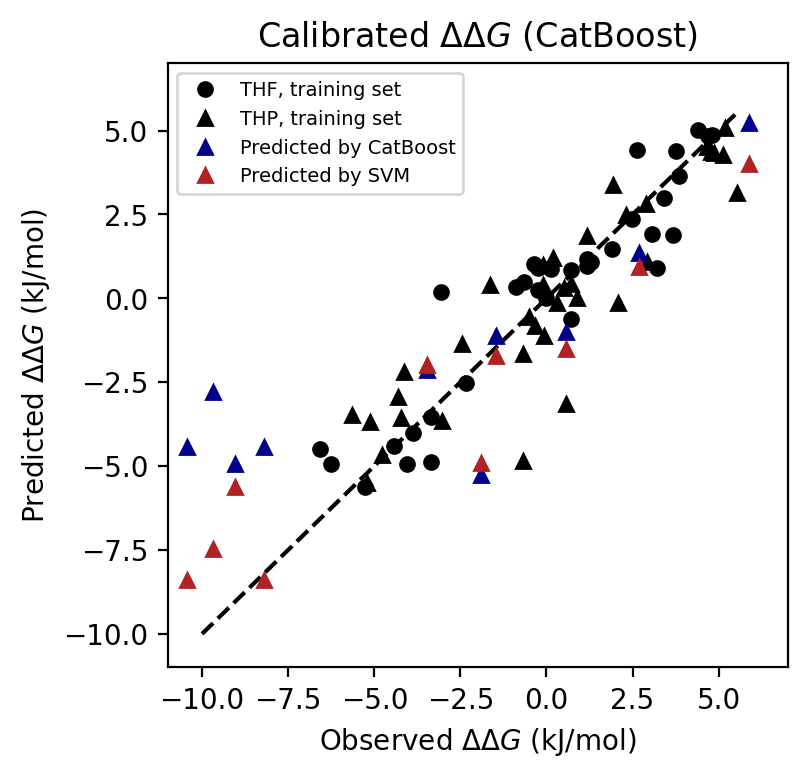

In [386]:
best_cbrmodel_full = gsr.best_estimator_

x, y  = load_svmlight_file("Final_model/sub-0-4+solvent.scaled.svm")
x = x.toarray()
THF_res_loo_ab = [cross_val_predict(best_cbrmodel_full, x, y, cv=KFold(n_splits=10)) for i in range(12)]

textstr = '\n'.join((
    'RMSE(10CV)=%.3f' % (rmse(y,np.mean(THF_res_loo_ab, axis=0)), ),
    'MAE(10CV)=%.3f' % (mae(y,np.mean(THF_res_loo_ab, axis=0)), ),
    'R2(10CV)=%.3f' % (r2(y,np.mean(THF_res_loo_ab, axis=0)), ),))
print(textstr)

best_cbrmodel_full.fit(x, y)
test_descs = best_model_full[:2].transform(data_THP_test)
cbr_test_preds = best_cbrmodel_full.predict(test_descs)

cbr_test_preds_decalib = calibrate(cbr_test_preds, 0.05, data_THP_test.concentration, cyh_calib_coef, 
                                 data_THP_test["T(K)"], calib_function)
er = np.array(ddg2fraction(cbr_test_preds_decalib, data_THP_test["T(K)"]))
    
for i in range(7):
    print("\t".join([str(ddg_THP_test[i]), str(np.round(cbr_test_preds_decalib[i], 3)), 
                     str(np.round(test_preds_decalib[i], 3)),
          str(np.round(er[i], 3)), str(np.round(er[i], 2))+":"+str(np.round(100-er[i], 2))]))

    
x = y
y = np.mean(THF_res_loo_ab, axis=0)
fig, ax = plt.subplots(figsize=(4,4), dpi=200, facecolor="white")

plt.plot(x[:35], y[:35], "ko", markersize=5, label="THF, training set")
plt.plot(x[35:], y[35:], "k^", markersize=5, label="THP, training set")
plt.plot([-10, 5.5], [-10, 5.5], "k--", label="_nolegend_")
plt.xticks(np.arange(-10,6))

plt.plot(calibrate(ddg_THP_test,  data_THP_test["concentration"], 0.05,
                   cyh_calib_coef, data_THP_test["T(K)"], calib_function), 
                   cbr_test_preds, "^", color="darkblue", markersize=5, label="Predicted by CatBoost")
plt.plot(calibrate(ddg_THP_test,  data_THP_test["concentration"], 0.05,
                   cyh_calib_coefcyh_poptb, data_THP_test["T(K)"], calib_function), 
                   test_preds, "^", color="firebrick", markersize=5, label="Predicted by SVM")

plt.title(r"Calibrated $\Delta \Delta G$ (CatBoost)")
plt.ylabel(r"Predicted $\Delta \Delta G$ (kJ/mol)")
plt.xlabel(r"Observed $\Delta \Delta G$ (kJ/mol)")
plt.xlim([-11, 7])
plt.ylim([-11, 7])
plt.xticks(np.arange(-10,7))
plt.yticks(np.arange(-10,7))
plt.legend(fontsize=7)
#plt.grid(color="lightgrey")
plt.xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5])
plt.yticks([-10, -7.5, -5, -2.5, 0, 2.5, 5])
plt.show()

### RandomForest models

In [254]:
from sklearn.ensemble import RandomForestRegressor

x, y  = load_svmlight_file("Benchmark/Benchmark_sub_solvent/sub-0-4+solvent.scaled.svm")
x = x.toarray()

param_grid = {'n_estimators': [10,20,30,50,100], "max_depth":[5,6,7,8,9,10]}
rfr = RandomForestRegressor()
gsr = GridSearchCV(rfr, param_grid, cv=10)
gsr.fit(x, y)

print(gsr.best_params_)
print(gsr.best_score_)

{'max_depth': 10, 'n_estimators': 20}
-2.1253126177451267


In [255]:
rfr_model = gsr.best_estimator_
THF_res_loo_ab = cross_val_predict(rfr_model, x, y, cv=KFold(n_splits=len(y)))

textstr = '\n'.join((
    'RMSE(LOO)=%.3f' % (rmse(y,THF_res_loo_ab), ),
    'MAE(LOO)=%.3f' % (mae(y,THF_res_loo_ab), ),
    'R2(LOO)=%.3f' % (r2(y,THF_res_loo_ab), ),))
print(textstr)

RMSE(LOO)=1.080
MAE(LOO)=0.816
R2(LOO)=0.887


In [387]:
x, y  = load_svmlight_file("Final_model/sub-0-4+solvent.scaled.svm")
x = x.toarray()

param_grid = {'n_estimators': [10,20,30,50,100], "max_depth":[5,6,7,8,9,10]}
rfr = RandomForestRegressor()
gsr = GridSearchCV(rfr, param_grid, cv=10)
gsr.fit(x, y)

print(gsr.best_params_)
print(gsr.best_score_)

{'max_depth': 6, 'n_estimators': 50}
0.8149996957692072


RMSE(10CV)=1.113
MAE(10CV)=0.852
R2(10CV)=0.880
-2.1904	-2.45	-1.259	29.226	29.23:70.77
-5.7074	-3.186	-3.548	24.048	24.05:75.95
-6.5822	-3.42	-5.291	22.538	22.54:77.46
0.355	-0.683	-0.948	43.87	43.87:56.13
3.7035	2.948	2.531	74.348	74.35:25.65
-6.1091	-3.357	-4.717	22.938	22.94:77.06
-0.9282	-0.849	-1.092	42.401	42.4:57.6


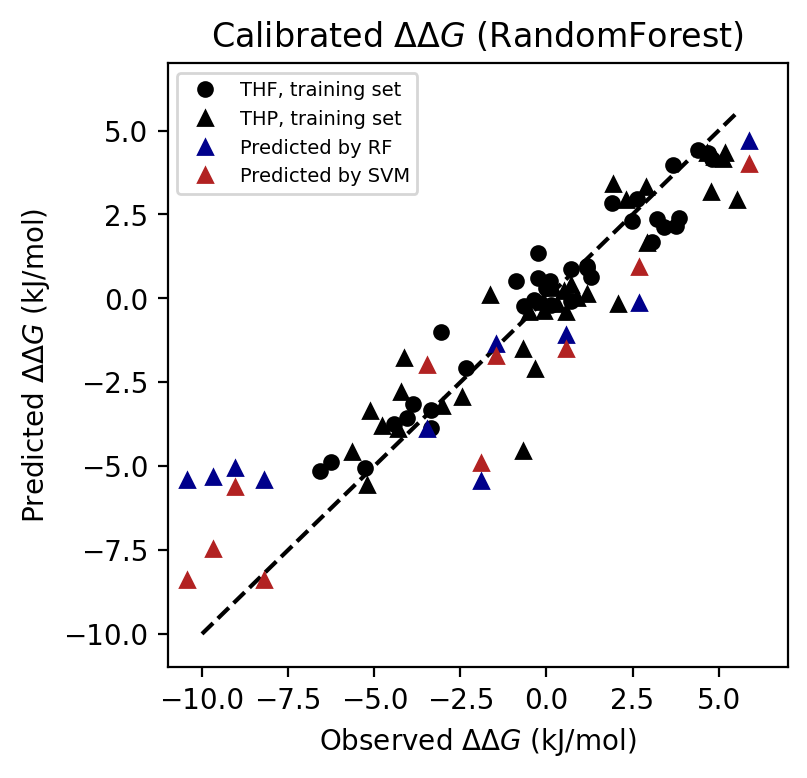

In [389]:
best_rfrmodel_full = gsr.best_estimator_

x, y  = load_svmlight_file("Final_model/sub-0-4+solvent.scaled.svm")
x = x.toarray()
THF_res_loo_ab = [cross_val_predict(best_rfrmodel_full, x, y, cv=KFold(n_splits=10)) for i in range(12)]

textstr = '\n'.join((
    'RMSE(10CV)=%.3f' % (rmse(y,np.mean(THF_res_loo_ab, axis=0)), ),
    'MAE(10CV)=%.3f' % (mae(y,np.mean(THF_res_loo_ab, axis=0)), ),
    'R2(10CV)=%.3f' % (r2(y,np.mean(THF_res_loo_ab, axis=0)), ),))
print(textstr)

best_rfrmodel_full.fit(x, y)
test_descs = best_model_full[:2].transform(data_THP_test)
rfr_test_preds = best_rfrmodel_full.predict(test_descs)

rfr_test_preds_decalib = calibrate(rfr_test_preds, 0.05, data_THP_test.concentration, cyh_calib_coef, 
                                 data_THP_test["T(K)"], calib_function)
er = np.array(ddg2fraction(rfr_test_preds_decalib, data_THP_test["T(K)"]))
    
for i in range(7):
    print("\t".join([str(ddg_THP_test[i]), str(np.round(rfr_test_preds_decalib[i], 3)), 
                     str(np.round(test_preds_decalib[i], 3)),
          str(np.round(er[i], 3)), str(np.round(er[i], 2))+":"+str(np.round(100-er[i], 2))]))

    
x = y
y = np.mean(THF_res_loo_ab, axis=0)
fig, ax = plt.subplots(figsize=(4,4), dpi=200, facecolor="white")

plt.plot(x[:35], y[:35], "ko", markersize=5, label="THF, training set")
plt.plot(x[35:], y[35:], "k^", markersize=5, label="THP, training set")
plt.plot([-10, 5.5], [-10, 5.5], "k--", label="_nolegend_")
plt.xticks(np.arange(-10,6))

plt.plot(calibrate(ddg_THP_test,  data_THP_test["concentration"], 0.05,
                   cyh_calib_coef, data_THP_test["T(K)"], calib_function), 
                   rfr_test_preds, "^", color="darkblue", markersize=5, label="Predicted by RF")
plt.plot(calibrate(ddg_THP_test,  data_THP_test["concentration"], 0.05,
                   cyh_calib_coefcyh_poptb, data_THP_test["T(K)"], calib_function), 
                   test_preds, "^", color="firebrick", markersize=5, label="Predicted by SVM")

plt.title(r"Calibrated $\Delta \Delta G$ (RandomForest)")
plt.ylabel(r"Predicted $\Delta \Delta G$ (kJ/mol)")
plt.xlabel(r"Observed $\Delta \Delta G$ (kJ/mol)")
plt.xlim([-11, 7])
plt.ylim([-11, 7])
plt.xticks(np.arange(-10,7))
plt.yticks(np.arange(-10,7))
plt.legend(fontsize=7)
#plt.grid(color="lightgrey")
plt.xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5])
plt.yticks([-10, -7.5, -5, -2.5, 0, 2.5, 5])
plt.show()

### YieldBert predictions

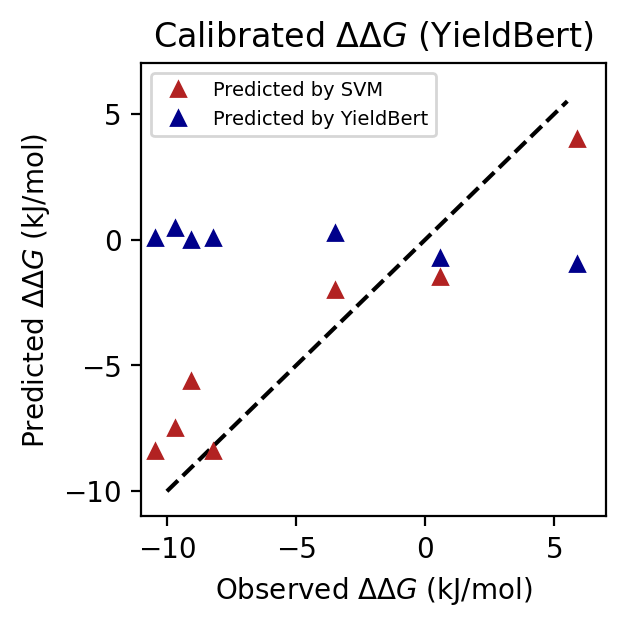

In [333]:
yieldbert_pred = [0.248, -0.011, 0.047, -0.714, -0.963, 0.461, 0.047]

fig, ax = plt.subplots(figsize=(3,3), dpi=200, facecolor="white")

plt.plot([-10, 5.5], [-10, 5.5], "k--", label="_nolegend_")
plt.xticks(np.arange(-10,6))
plt.plot(calibrate(ddg_THP_test,  data_THP_test["concentration"], 0.05,
                   cyh_calib_coef, data_THP_test["T(K)"], calib_function), 
                   test_preds, "^", color="firebrick", markersize=5, label="Predicted by SVM")
plt.plot(calibrate(ddg_THP_test,  data_THP_test["concentration"], 0.05,
                   cyh_calib_coefcyh_poptb, data_THP_test["T(K)"], calib_function), 
                   yieldbert_pred, "^", color="darkblue", markersize=5, label="Predicted by YieldBert")
plt.title(r"Calibrated $\Delta \Delta G$ (YieldBert)")
plt.ylabel(r"Predicted $\Delta \Delta G$ (kJ/mol)")
plt.xlabel(r"Observed $\Delta \Delta G$ (kJ/mol)")
plt.xlim([-11, 7])
plt.ylim([-11, 7])
plt.legend(fontsize=7)
#plt.grid(color="lightgrey")
plt.xticks([-10, -5,  0, 5])
plt.yticks([-10, -5, 0,  5])
plt.show()

### "Two-hot" encoding for the final model

In [217]:
full_Ar_OH = list(set(data_full_train.Ar))
full_R_OH = list(set(data_full_train.R))
desc_oh_full = np.zeros((len(ddg_full_train), len(full_Ar_OH)+len(full_R_OH)+4), dtype=int)
for i, row in enumerate(data_full_train.Ar):
    desc_oh_full[i, full_Ar_OH.index(row)] = 1
for i, row in enumerate(data_full_train.R):
    desc_oh_full[i, full_R_OH.index(row)+len(full_Ar_OH)] = 1
for i, row in enumerate(data_full_train.solvent):
    if i<35:
        desc_oh_full[i, -4] = 1
    else:
        desc_oh_full[i, -3] = 1
    if row=="toluene":
        desc_oh_full[i, -2] = 1
    else:
        desc_oh_full[i, -1] = 1


In [257]:
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], "coef0":[-10,-5,-1,0,1,5,10], "epsilon":[0.1,0.5,1], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], "coef0":[-10,-5,-1,0,1,5,10], "epsilon":[0.1,0.5,1], 'gamma': ["scale", "auto"], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], "coef0":[-10,-5,-1,0,1,5,10], "epsilon":[0.1,0.5,1], 'kernel': ['poly']},
  {'C': [0.1, 1, 10, 100, 1000], "coef0":[-10,-5,-1,0,1,5,10], "epsilon":[0.1,0.5,1], 'gamma': ["scale", "auto"], 'kernel': ['sigmoid']}
 ]
svr = SVR()
gsr = GridSearchCV(svr, param_grid, cv=KFold(n_splits=10))
gsr.fit(desc_oh_full, ddg_full_train)

print(gsr.best_params_)
print(gsr.best_score_)

oh_model = gsr.best_estimator_ 
oh_res = cross_val_predict(oh_model, desc_oh_full, ddg_full_train, cv=KFold(n_splits=10))
oh_r2 = [r2(ddg_full_train, r) for r in oh_res]
textstr = '\n'.join((
    'RMSE(CV)=%.3f' % (rmse(ddg_full_train, oh_res), ),
    'MAE(CV)=%.3f' % (mae(ddg_full_train, oh_res), ),
    'R2(CV)=%.3f' % (r2(ddg_full_train, oh_res), ),))
print(textstr)


{'C': 1000, 'coef0': -1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
-0.09004073082663444
RMSE(CV)=2.454
MAE(CV)=1.829
R2(CV)=0.419


## CircuS descriptors general application

In [11]:
from glob import glob

Denmark_models = {}

for m in glob("Other dataset/Model_*"):
    desc_type = m[20:]
    Denmark_models[desc_type] = {}
    Denmark_models[desc_type]["location"] = m
    Denmark_models[desc_type]["params"] = pd.read_table(m+"/best_pop", header=None, delimiter=" ").iloc[0]
    Denmark_models[desc_type]["descs"], _ = load_svmlight_file(m+"/"+Denmark_models[desc_type]["params"][0]+"."+Denmark_models[desc_type]["params"][1]+".svm")
    Denmark_models[desc_type]["descs"] = Denmark_models[desc_type]["descs"].toarray()
    with open(m+"/"+Denmark_models[desc_type]["params"][8]+"/svm.pars") as f:
        Denmark_models[desc_type]["svm_params"] = f.readline().strip()

Denmark_dict = {}
for m in Denmark_models.keys():
    opt_obs = np.loadtxt(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_test.pred.gz")[:,1]
    opt_pred = np.loadtxt(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_test.pred.gz")[:,2:].mean(axis=1)
    cat_file = glob(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_cat.*.pred.gz")[0]
    cat_obs = np.loadtxt(cat_file)[:,0]
    cat_pred = np.loadtxt(cat_file)[:,1]
    sub_file = glob(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_sub.*.pred.gz")[0]
    sub_obs = np.loadtxt(sub_file)[:,0]
    sub_pred = np.loadtxt(sub_file)[:,1]
    cat_sub_file = glob(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_cat_sub.*.pred.gz")[0]
    cat_sub_obs = np.loadtxt(cat_sub_file)[:,0]
    cat_sub_pred = np.loadtxt(cat_sub_file)[:,1]
    Denmark_dict[m] = {"MAE(CVopt)":mae(opt_obs, opt_pred), 
                 "RMSE(CVopt)":rmse(opt_obs, opt_pred), "R2(CVopt)":r2(opt_obs, opt_pred),
                "MAE(cat)":mae(cat_obs, cat_pred), "RMSE(cat)":rmse(cat_obs, cat_pred), 
                 "R2(cat)":r2(cat_obs, cat_pred),
                "MAE(sub)":mae(sub_obs, sub_pred), "RMSE(sub)":rmse(sub_obs, sub_pred),
                 "R2(sub)":r2(sub_obs, sub_pred),
                "MAE(sub-cat)":mae(cat_sub_obs, cat_sub_pred), 
                 "RMSE(sub-cat)":rmse(cat_sub_obs, cat_sub_pred), 
                 "R2(sub-cat)":r2(cat_sub_obs, cat_sub_pred)}

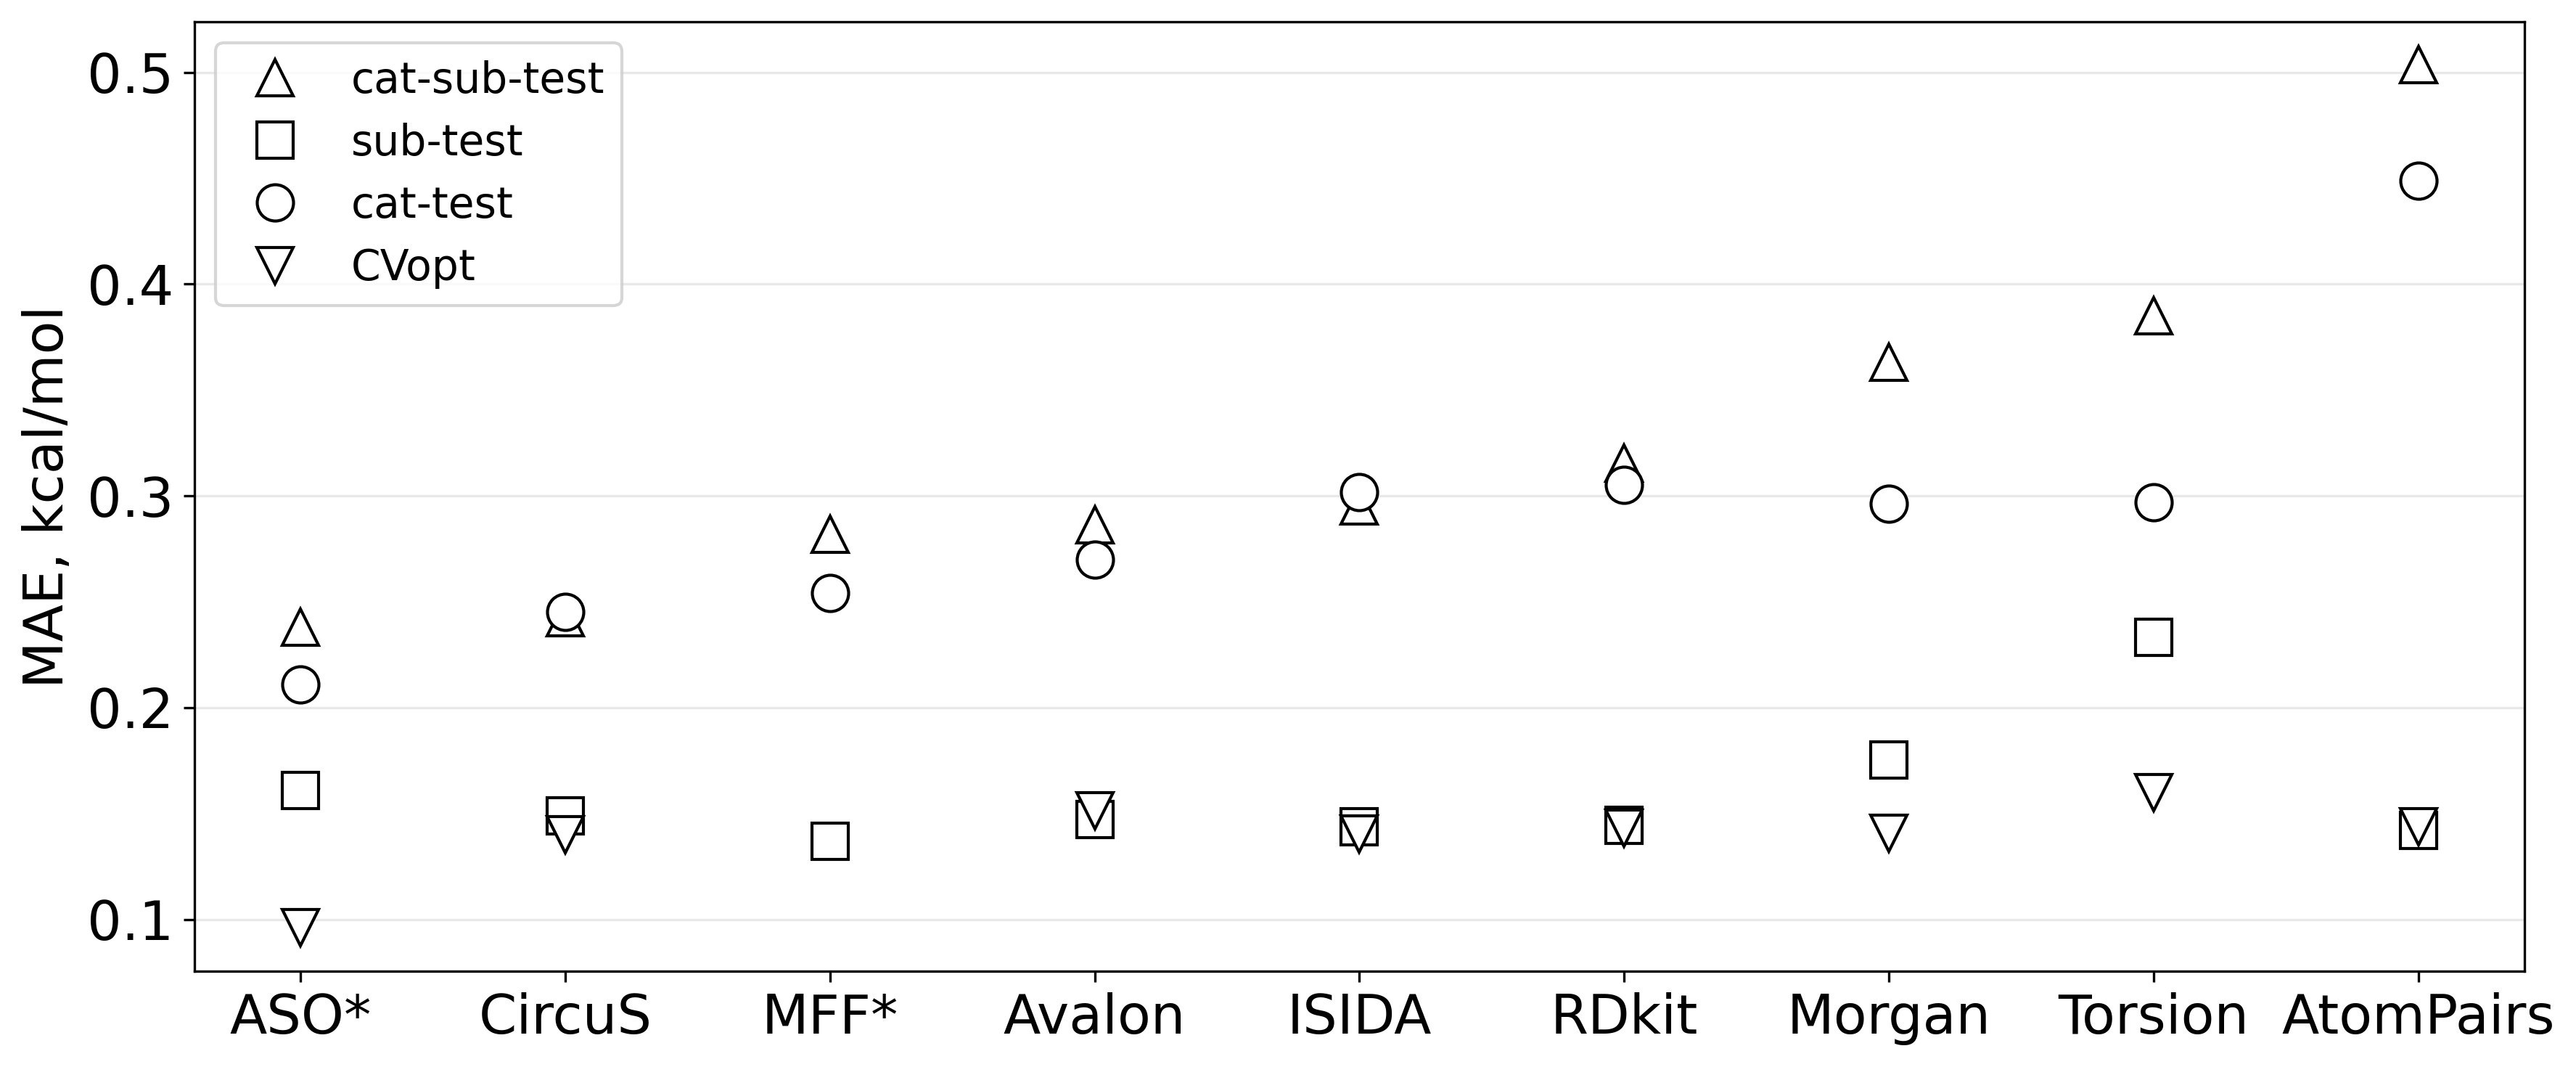

In [12]:
performance_table = pd.DataFrame(Denmark_dict) 
performance_table = performance_table.transpose()
performance_table = performance_table.append({"MAE(sub)":0.161,"MAE(sub-cat)":0.238,
                                                      "MAE(CVopt)":0.096,"MAE(cat)":0.211}, ignore_index=True)
performance_table = performance_table.append({"MAE(sub)":0.137,"MAE(sub-cat)":0.282,
                                                      "MAE(CVopt)":np.nan,"MAE(cat)":0.254}, ignore_index=True)
performance_table["name"] =  ["ISIDA\n(cat+sub)", "Morgan", "AtomPairs", "ISIDA", 
                              "CircuS\n(cat+sub)", 'Torsion', "CircuS", "RDkit",
                              "Avalon","ASO*","MFF*"] 

performance_table_extract = performance_table.drop(labels=[0,4], axis=0).reset_index()

fig, ax = plt.subplots(figsize=(12,5), dpi=300, facecolor="white")
ax.plot(np.arange(len(performance_table_extract)),
        performance_table_extract["MAE(sub-cat)"].sort_values(), 
        "k^", label="cat-sub-test", markerfacecolor="w", markersize=12)
xticks = performance_table_extract["MAE(sub-cat)"].sort_values().index
ax.plot(np.arange(len(performance_table_extract)),
        performance_table_extract.iloc[xticks]["MAE(sub)"], 
        "ks", label="sub-test", markerfacecolor="w", markersize=12)
ax.plot(np.arange(len(performance_table_extract)),
        performance_table_extract.iloc[xticks]["MAE(cat)"], 
        "ko", label="cat-test", markerfacecolor="w", markersize=12)
ax.plot(np.arange(len(performance_table_extract)),
        performance_table_extract.iloc[xticks]["MAE(CVopt)"], 
        "kv", label="CVopt", markerfacecolor="w", markersize=12)

plt.legend(fontsize=14)
ax.set_xticks(np.arange(len(performance_table_extract)))
ax.set_xticklabels(list(performance_table_extract.iloc[xticks]["name"]), fontsize=14)
ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_ylabel("MAE, kcal/mol")#, rotation=0, labelpad=-15, loc="top")
ax.grid(color="lightgrey", axis="y", alpha=.5)

for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.tight_layout()
plt.show()

In [13]:
performance_table

,MAE(CVopt),RMSE(CVopt),R2(CVopt),MAE(cat),RMSE(cat),R2(cat),MAE(sub),RMSE(sub),R2(sub),MAE(sub-cat),RMSE(sub-cat),R2(sub-cat),name
0,0.153603,0.201264,0.908403,0.346316,0.491376,0.509683,0.296563,0.405783,0.656059,0.522972,0.699403,0.094731,ISIDA\n(cat+sub)
1,0.140654,0.199658,0.909859,0.296465,0.440358,0.606215,0.175331,0.249159,0.870326,0.362989,0.531136,0.477923,Morgan
2,0.143625,0.193412,0.915411,0.448665,0.618374,0.223483,0.141917,0.196120,0.919658,0.503505,0.684275,0.133469,AtomPairs
3,0.140249,0.189200,0.919054,0.301729,0.400027,0.675042,0.143719,0.192318,0.922743,0.295325,0.395124,0.711071,ISIDA
4,0.139700,0.183368,0.923968,0.309511,0.416652,0.647471,0.154927,0.206153,0.911228,0.331560,0.449679,0.625779,CircuS\n(cat+sub)
5,0.159721,0.211090,0.899240,0.296838,0.402876,0.670398,0.233122,0.314181,0.793815,0.385227,0.534383,0.471520,Torsion
6,0.140151,0.186112,0.921675,0.245100,0.319859,0.792238,0.148786,0.194005,0.921382,0.242407,0.318195,0.812626,CircuS
7,0.143226,0.193185,0.915609,0.305203,0.393913,0.684899,0.144618,0.193002,0.922192,0.315370,0.404195,0.697653,RDkit
8,0.151278,0.191427,0.917138,0.269787,0.363957,0.731002,0.147199,0.199599,0.916782,0.286262,0.392745,0.714540,Avalon
9,0.096000,NaN,NaN,0.211000,NaN,NaN,0.161000,NaN,NaN,0.238000,NaN,NaN,ASO*


RMSE = 0.779
MAE = 0.586
R2 = 0.922


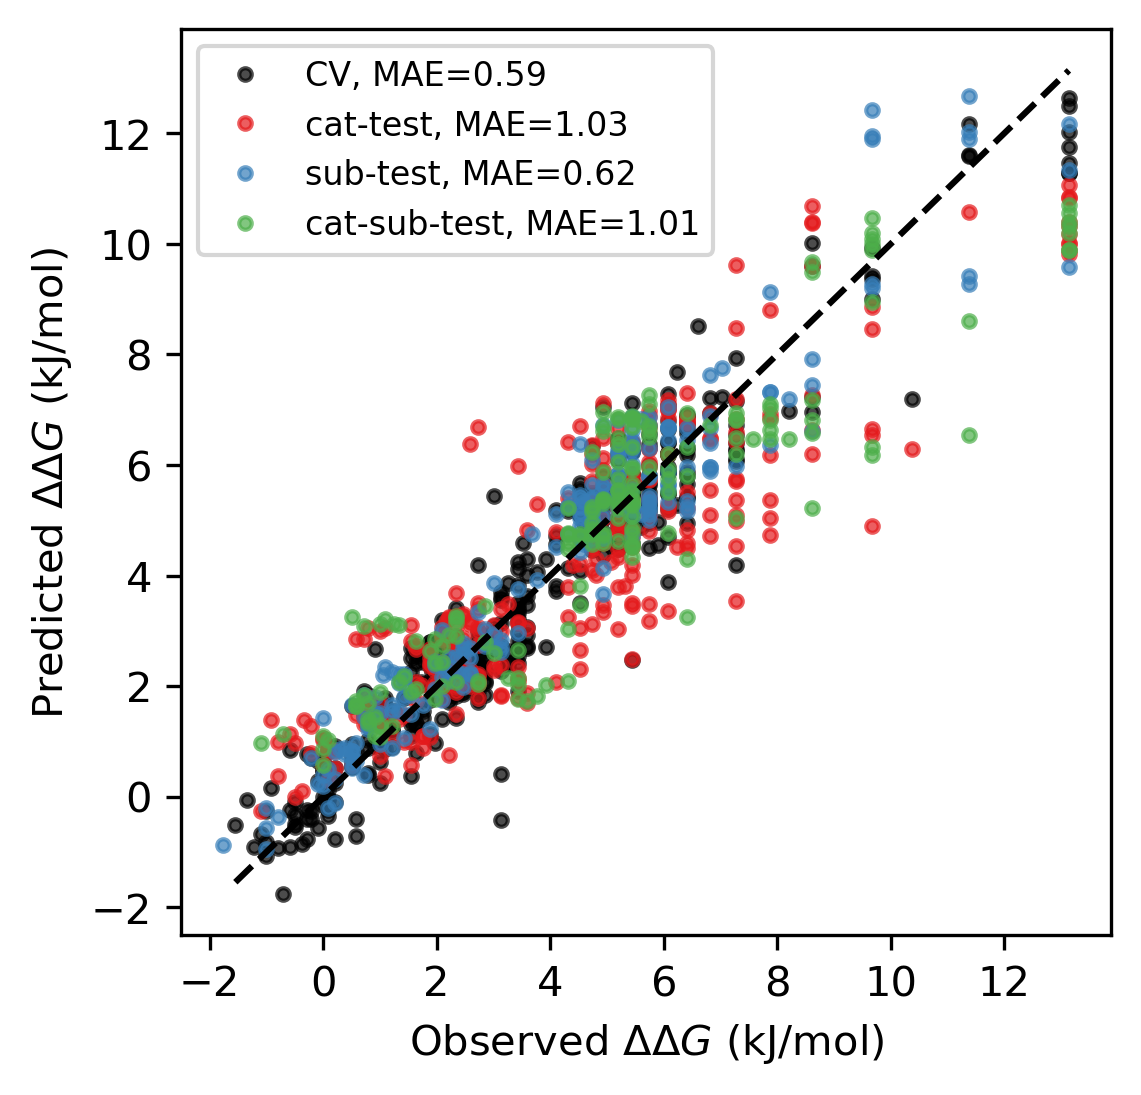

In [275]:
for m in ["CR_circus"]:
    opt_obs = np.loadtxt(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_test.pred.gz")[:,1]*4.184
    opt_pred = np.loadtxt(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_test.pred.gz")[:,2:].mean(axis=1)*4.184
    cat_file = glob(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_cat.*.pred.gz")[0]
    cat_obs = np.loadtxt(cat_file)[:,0]*4.184
    cat_pred = np.loadtxt(cat_file)[:,1]*4.184
    sub_file = glob(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_sub.*.pred.gz")[0]
    sub_obs = np.loadtxt(sub_file)[:,0]*4.184
    sub_pred = np.loadtxt(sub_file)[:,1]*4.184
    cat_sub_file = glob(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_cat_sub.*.pred.gz")[0]
    cat_sub_obs = np.loadtxt(cat_sub_file)[:,0]*4.184
    cat_sub_pred = np.loadtxt(cat_sub_file)[:,1]*4.184

fig, ax = plt.subplots(figsize=(4,4), dpi=300, facecolor="white")

ax.plot(opt_obs, opt_pred, "ko", markersize=3, alpha=0.7, 
        label=f"CV, MAE="+str(np.round(mae(opt_obs, opt_pred),2)))
ax.plot(cat_obs, cat_pred, "o", color="#e41a1c", markersize=3, alpha=0.7, 
        label="cat-test, MAE="+str(np.round(mae(cat_obs, cat_pred),2)))
ax.plot(sub_obs, sub_pred, "o", color="#377eb8", markersize=3, alpha=0.7, 
        label="sub-test, MAE="+str(np.round(mae(sub_obs, sub_pred),2)))
ax.plot(cat_sub_obs, cat_sub_pred, "o", color="#4daf4a", markersize=3, alpha=0.7, 
        label="cat-sub-test, MAE="+str(np.round(mae(cat_sub_obs, cat_sub_pred),2)))
ax.plot([opt_obs.min(), opt_obs.max()], [opt_obs.min(), opt_obs.max()], "k--")
ax.set_xticks([-2,0,2,4,6,8,10,12])
ax.set_yticks([-2,0,2,4,6,8,10,12])
ax.legend(fontsize=8)
plt.ylabel(r"Predicted $\Delta \Delta G$ (kJ/mol)")
plt.xlabel(r"Observed $\Delta \Delta G$ (kJ/mol)")
textstr = "\n".join([
    "RMSE = %.3f"  % (rmse(opt_obs, opt_pred), ),
    "MAE = %.3f"  % (mae(opt_obs, opt_pred), ),
    "R2 = %.3f"  % (r2(opt_obs, opt_pred), )
])
print(textstr)

RMSE = 0.186
MAE = 0.140
R2 = 0.922


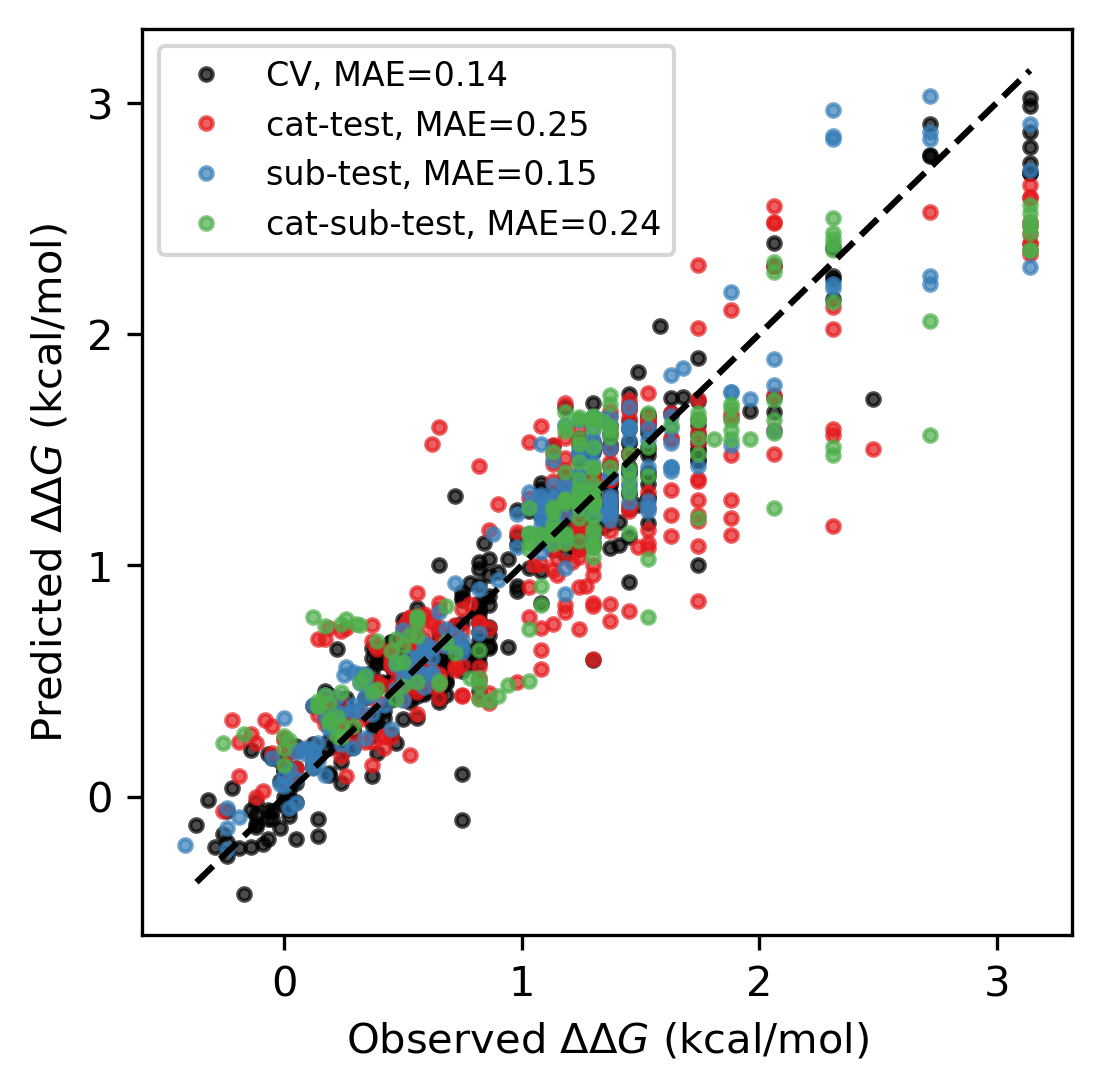

In [277]:
for m in ["CR_circus"]:
    opt_obs = np.loadtxt(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_test.pred.gz")[:,1]
    opt_pred = np.loadtxt(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_test.pred.gz")[:,2:].mean(axis=1)
    cat_file = glob(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_cat.*.pred.gz")[0]
    cat_obs = np.loadtxt(cat_file)[:,0]
    cat_pred = np.loadtxt(cat_file)[:,1]
    sub_file = glob(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_sub.*.pred.gz")[0]
    sub_obs = np.loadtxt(sub_file)[:,0]
    sub_pred = np.loadtxt(sub_file)[:,1]
    cat_sub_file = glob(Denmark_models[m]["location"]+"/"+Denmark_models[m]["params"][8]+"/final_cat_sub.*.pred.gz")[0]
    cat_sub_obs = np.loadtxt(cat_sub_file)[:,0]
    cat_sub_pred = np.loadtxt(cat_sub_file)[:,1]

fig, ax = plt.subplots(figsize=(4,4), dpi=300, facecolor="white")

ax.plot(opt_obs, opt_pred, "ko", markersize=3, alpha=0.7, 
        label=f"CV, MAE="+str(np.round(mae(opt_obs, opt_pred),2)))
ax.plot(cat_obs, cat_pred, "o", color="#e41a1c", markersize=3, alpha=0.7, 
        label="cat-test, MAE="+str(np.round(mae(cat_obs, cat_pred),2)))
ax.plot(sub_obs, sub_pred, "o", color="#377eb8", markersize=3, alpha=0.7, 
        label="sub-test, MAE="+str(np.round(mae(sub_obs, sub_pred),2)))
ax.plot(cat_sub_obs, cat_sub_pred, "o", color="#4daf4a", markersize=3, alpha=0.7, 
        label="cat-sub-test, MAE="+str(np.round(mae(cat_sub_obs, cat_sub_pred),2)))
ax.plot([opt_obs.min(), opt_obs.max()], [opt_obs.min(), opt_obs.max()], "k--")
ax.set_xticks([0,1,2,3])
ax.set_yticks([0,1,2,3])
ax.legend(fontsize=8)
plt.ylabel(r"Predicted $\Delta \Delta G$ (kcal/mol)")
plt.xlabel(r"Observed $\Delta \Delta G$ (kcal/mol)")
textstr = "\n".join([
    "RMSE = %.3f"  % (rmse(opt_obs, opt_pred), ),
    "MAE = %.3f"  % (mae(opt_obs, opt_pred), ),
    "R2 = %.3f"  % (r2(opt_obs, opt_pred), )
])
print(textstr)

## Out-of-sample model

In [291]:
data_full_nobest = data_full_train.copy()
data_full_nobest = data_full_nobest.reset_index()

data_full_extracted = data_full_nobest[(data_full_nobest.Ar == "[C:2][c:1]1ccc(cc1)C(C)(C)C") | (data_full_nobest.R == "Fc1c(F)c(F)c2c(F)c(c(F)c(F)c2c1F)S(=O)=O")]

data_full_nobest = data_full_nobest.drop(data_full_nobest[data_full_nobest.Ar == "[C:2][c:1]1ccc(cc1)C(C)(C)C"].index,
                                       axis=0)

data_full_nobest = data_full_nobest.drop(data_full_nobest[data_full_nobest.R == "Fc1c(F)c(F)c2c(F)c(c(F)c(F)c2c1F)S(=O)=O"].index,
                                       axis=0)


In [157]:
fms = pd.read_table("Final_model/best_pop", header=None, delimiter=" ").iloc[0]
with open("Final_model/"+fms[8]+"/svm.pars") as f:
    best_model_part = Pipeline([("fragmentor",ComplexFragmentor(associator={"mol_Ar":Augmentor(lower=0, upper=4),
                                                   "mol_R":Augmentor(lower=0, upper=2),
                                                   "CGR":Augmentor(lower=0, upper=2),
                                                   "solvent":solvent.SolventVectorizer()},
                                       structure_columns=["mol_Ar", "mol_R", "CGR"])),
          #("selector", VarianceThreshold()), ("scaler", MinMaxScaler()),
          ("pruner",Pruner("Final_model/"+fms[0]+".pri", scaling=fms[1]=="scaled")),
          ("model",libsvm_parser(f.read().strip()))])

In [158]:
best_model_part[0].fit(data_full_train)
descs_part = best_model_part[0].transform(data_full_nobest)
descs_part_norm = best_model_part[1].transform(descs_part)
best_model_part.fit(data_full_nobest, ddg_full_train[data_full_nobest.index])

Pipeline(steps=[('fragmentor',
                 ComplexFragmentor(associator={'CGR': Augmentor(upper=2),
                                               'mol_Ar': Augmentor(upper=4),
                                               'mol_R': Augmentor(upper=2),
                                               'solvent': SolventVectorizer()},
                                   structure_columns=['mol_Ar', 'mol_R',
                                                      'CGR'])),
                ('pruner', Pruner(prifile='Final_model/sub-0-4+solvent.pri')),
                ('model',
                 SVR(C=445.8578, coef0=-8.4, epsilon=0.965829, gamma='auto'))])

In [292]:
test_preds_part = best_model_part.predict(data_THP_test)
extracted_preds_part = best_model_part.predict(data_full_extracted)

RMSE(CV)=1.221
MAE(CV)=0.987
R2(CV)=0.856


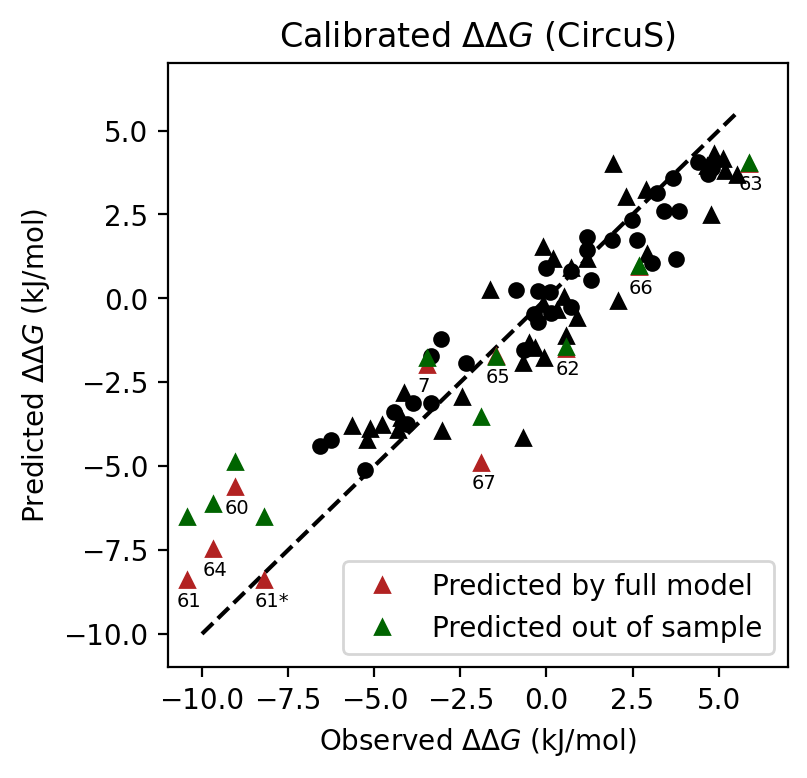

RMSE(CV)=2.934
MAE(CV)=2.216
R2(CV)=0.170


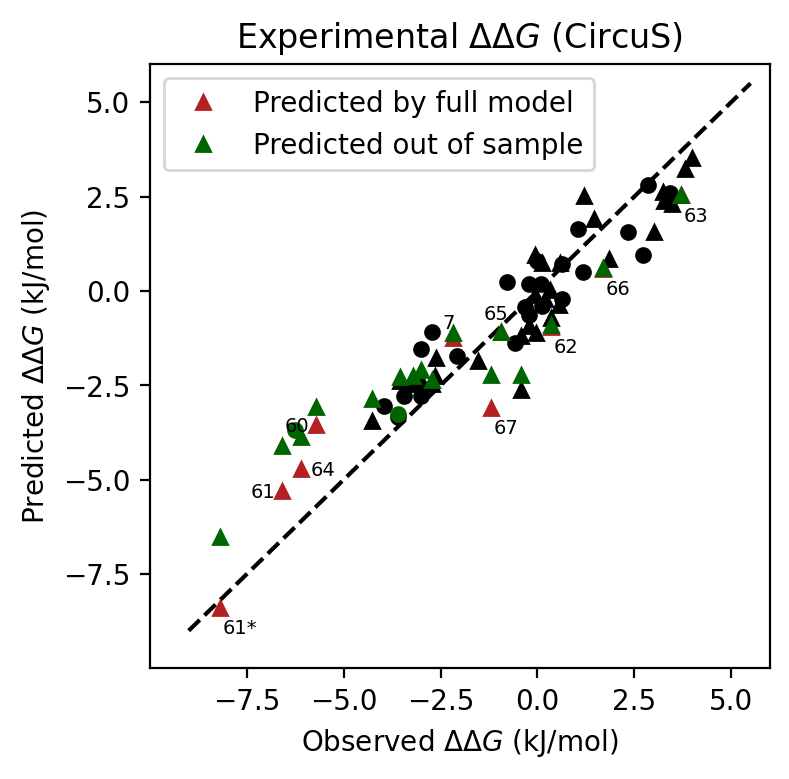

In [350]:
full_model_cv = np.loadtxt("Final_model/"+fms[8]+"/final_test.pred.gz")

x = ddg_full_train
y = np.mean(full_model_cv[:,2:], axis=1)

fig, ax = plt.subplots(figsize=(4,4), dpi=200, facecolor="white")

plt.plot(x[:35], y[:35], "ko", markersize=5, label="_nolegend_")
plt.plot(x[35:], y[35:], "k^", markersize=5, label="_nolegend_")
plt.plot([-10, 5.5], [-10, 5.5], "k--", label="_nolegend_")
plt.xticks(np.arange(-10,6))

test_preds = best_model_full.predict(data_THP_test)

textstr = '\n'.join((
    'RMSE(CV)=%.3f' % (rmse(x, y), ),
    'MAE(CV)=%.3f' % (mae(x, y), ),
    'R2(CV)=%.3f' % (r2(x, y), ),))
print(textstr)

plt.plot(calibrate(ddg_THP_test,  data_THP_test["concentration"], 0.05,
                   cyh_calib_coef, data_THP_test["T(K)"], calib_function), 
                   test_preds, "^", color="firebrick", markersize=5, label="Predicted by full model")
plt.plot(calibrate(ddg_THP_test,  data_THP_test["concentration"], 0.05,
                   cyh_calib_coef, data_THP_test["T(K)"], calib_function), 
                   test_preds_part, "^", color="darkgreen", markersize=5, label="Predicted out of sample")
for i, row in data_THP_test.iterrows():
    if i==len(data_THP_test)-1:
        plt.annotate(str(row['name'])+'*', (calibrate(ddg_THP_test[i],  data_THP_test.iloc[i]["concentration"], 0.05,
                   cyh_calib_coef, data_THP_test.iloc[i]["T(K)"], calib_function), 
                   test_preds[i]), xytext=(-3.5, -9.5), textcoords="offset points", fontsize=7)
    else:
        plt.annotate(row['name'], (calibrate(ddg_THP_test[i],  data_THP_test.iloc[i]["concentration"], 0.05,
                   cyh_calib_coefcyh_poptb, data_THP_test.iloc[i]["T(K)"], calib_function), 
                   test_preds[i]), xytext=(-3.5, -9.5), textcoords="offset points", fontsize=7)

plt.title(r"Calibrated $\Delta \Delta G$ (CircuS)")
plt.ylabel(r"Predicted $\Delta \Delta G$ (kJ/mol)")
plt.xlabel(r"Observed $\Delta \Delta G$ (kJ/mol)")
plt.xlim([-11, 7])
plt.ylim([-11, 7])
plt.xticks(np.arange(-10,7))
plt.yticks(np.arange(-10,7))
plt.legend()
#plt.grid(color="lightgrey")
plt.xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5])
plt.yticks([-10, -7.5, -5, -2.5, 0, 2.5, 5])
plt.show()

THF_tol_ind = data_THF[data_THF.solvent == "toluene"].index
THF_cyh_ind = data_THF[data_THF.solvent == "cyclohexane"].index

y_THF_tol_decalib = calibrate(y[THF_tol_ind], 0.05, data_THF.iloc[THF_tol_ind]["concentration"], 
                              tol_calib_coef, data_THF.iloc[THF_tol_ind]["T(K)"], calib_function)

y_THF_cyh_decalib = calibrate(y[THF_cyh_ind], 0.05, data_THF.iloc[THF_cyh_ind]["concentration"], 
                              cyh_calib_coef, data_THF.iloc[THF_cyh_ind]["T(K)"], calib_function)

y_THP_decalib = calibrate(y[35:], 0.05, data_THP_train["concentration"], cyh_calib_coefcyh_poptb, 
                          data_THP_train["T(K)"], calib_function)

fig, ax = plt.subplots(figsize=(4,4), dpi=200, facecolor="white")

plt.plot(np.delete(ddg_THF[THF_tol_ind],data_full_extracted.level_0[0]), 
         np.delete(y_THF_tol_decalib,data_full_extracted.level_0[0]),
         "ko", markersize=5, label="_nolegend_")
#plt.plot(np.delete(ddg_THF[THF_cyh_ind],data_full_extracted.level_0[1]), 
#         np.delete(y_THF_cyh_decalib,data_full_extracted.level_0[1]),
#         "ko", markersize=5, label="_nolegend_")
plt.plot(np.delete(ddg_THP_train, data_full_extracted.index[2:]), 
         np.delete(y_THP_decalib, data_full_extracted.index[2:]), 
         "k^", markersize=5, label="_nolegend_")
plt.plot([-9, 5.5], [-9, 5.5], "k--", label="_nolegend_")

plt.plot(ddg_THP_test, calibrate(test_preds, 0.05, data_THP_test.concentration, cyh_calib_coef, 
                                 data_THP_test["T(K)"], calib_function), 
         "^", color="firebrick", markersize=5, label="Predicted by full model")
plt.plot(ddg_THP_test, calibrate(test_preds_part, 0.05, data_THP_test.concentration, cyh_calib_coefcyh_poptb, 
                                 data_THP_test["T(K)"], calib_function), 
         "^", color="darkgreen", markersize=5, label="Predicted out of sample")
plt.plot(data_THF.iloc[data_full_extracted.level_0[0]]["ddG"], 
         calibrate(extracted_preds_part[0], 0.05, 
                   data_full_train.iloc[data_full_extracted.level_0[0]].concentration, tol_calib_coeftol_poptb, 
                   data_full_train.iloc[data_full_extracted.level_0[0]]["T(K)"], calib_function), 
         "o", color="darkgreen", markersize=5)
plt.plot(data_THF.iloc[data_full_extracted.level_0[1]]["ddG"], 
         calibrate(extracted_preds_part[1], 0.05, 
                   data_full_train.iloc[data_full_extracted.level_0[1]].concentration, cyh_calib_coef, 
                   data_full_train.iloc[data_full_extracted.level_0[1]]["T(K)"], calib_function), 
         "o", color="darkgreen", markersize=5)
plt.plot(data_full_train.iloc[data_full_extracted.level_0[2:]]["ddG"], 
         calibrate(extracted_preds_part[2:], 0.05, 
                   data_full_train.iloc[data_full_extracted.level_0[2:]].concentration, cyh_calib_coef, 
                   data_full_train.iloc[data_full_extracted.level_0[2:]]["T(K)"], calib_function), 
         "^", color="darkgreen", markersize=5)

for i, row in data_THP_test.iterrows():
    if i==len(data_THP_test)-1:
        plt.annotate(str(row['name'])+'*', (ddg_THP_test[i], 
                                            calibrate(test_preds[i], 0.05, data_THP_test.iloc[i].concentration, 
                                            cyh_calib_coef, data_THP_test.iloc[i]["T(K)"], calib_function)), 
                                            xytext=(1, -9.5), textcoords="offset points", fontsize=7)
    elif row['name'] in [67, 62, 66, 63]:
        plt.annotate(str(row['name']), (ddg_THP_test[i], 
                                            calibrate(test_preds[i], 0.05, data_THP_test.iloc[i].concentration, 
                                            cyh_calib_coef, data_THP_test.iloc[i]["T(K)"], calib_function)), 
                                            xytext=(1, -9.5), textcoords="offset points", fontsize=7)
    elif row['name'] in [60,61]:
        plt.annotate(str(row['name']), (ddg_THP_test[i], 
                                            calibrate(test_preds[i], 0.05, data_THP_test.iloc[i].concentration, 
                                            cyh_calib_coef, data_THP_test.iloc[i]["T(K)"], calib_function)), 
                                            xytext=(-11.5, -2.5), textcoords="offset points", fontsize=7)
    elif row['name'] in [64]:
        plt.annotate(str(row['name']), (ddg_THP_test[i], 
                                            calibrate(test_preds[i], 0.05, data_THP_test.iloc[i].concentration, 
                                            cyh_calib_coefcyh_poptb, data_THP_test.iloc[i]["T(K)"], calib_function)), 
                                            xytext=(3.5, -2.5), textcoords="offset points", fontsize=7)
    elif row['name'] in [65]:
        plt.annotate(str(row['name']), (ddg_THP_test[i], 
                                            calibrate(test_preds[i], 0.05, data_THP_test.iloc[i].concentration, 
                                            cyh_calib_coef, data_THP_test.iloc[i]["T(K)"], calib_function)), 
                                            xytext=(-6.5, 4.5), textcoords="offset points", fontsize=7)
    else:
        plt.annotate(row['name'], (ddg_THP_test[i], 
                                            calibrate(test_preds[i], 0.05, data_THP_test.iloc[i].concentration, 
                                            cyh_calib_coefcyh_poptb, data_THP_test.iloc[i]["T(K)"], calib_function)), 
                                            xytext=(-3.5, 3.5), textcoords="offset points", fontsize=7)

plt.xlim([-10, 6])
plt.ylim([-10, 6])
plt.xticks([-7.5, -5, -2.5, 0, 2.5, 5])
plt.yticks([-7.5, -5, -2.5, 0, 2.5, 5])
#plt.grid(color="lightgrey")
plt.title(r"Experimental $\Delta \Delta G$ (CircuS)")
plt.ylabel(r"Predicted $\Delta \Delta G$ (kJ/mol)")
plt.xlabel(r"Observed $\Delta \Delta G$ (kJ/mol)")
plt.legend()

textstr = '\n'.join((
    'RMSE(CV)=%.3f' % (rmse(x, y_decalib), ),
    'MAE(CV)=%.3f' % (mae(x, y_decalib), ),
    'R2(CV)=%.3f' % (r2(x, y_decalib), ),))
print(textstr)

### Predictions by alternative models (Avalon and "two-hot" encoding)

In [298]:
oh_model = SVR(C=100, coef0=-1, epsilon=0.1, kernel='sigmoid', gamma='scale')
#oh_model = gsr.best_estimator_ 
oh_model.fit(desc_oh_full[data_full_nobest.index, :], ddg_full_train[data_full_nobest.index])

desc_oh_test = np.zeros((len(data_THP_test), len(full_Ar_OH)+len(full_R_OH)+4), dtype=int)
for i, row in data_THP_test.iterrows():
    if row['Ar'] in full_Ar_OH:
        desc_oh_test[i, full_Ar_OH.index(row['Ar'])] = 1
    if row['R'] in full_R_OH:
        desc_oh_test[i, full_R_OH.index(row['R'])+len(full_Ar_OH)] = 1
    desc_oh_test[i, -3] = 1
    desc_oh_test[i, -1] = 1

oh_preds = oh_model.predict(desc_oh_test)

data_full_extracted = data_full_extracted.reset_index()
desc_oh_extracted = np.zeros((len(data_full_extracted), len(full_Ar_OH)+len(full_R_OH)+4), dtype=int)
for i, row in data_full_extracted.iterrows():
    if row['Ar'] in full_Ar_OH:
        desc_oh_extracted[i, full_Ar_OH.index(row['Ar'])] = 1
    if row['R'] in full_R_OH:
        desc_oh_extracted[i, full_R_OH.index(row['R'])+len(full_Ar_OH)] = 1
    if i<35:
        desc_oh_extracted[i, -4] = 1
    else:
        desc_oh_extracted[i, -3] = 1
    if row["solvent"] == "toluene":
        desc_oh_extracted[i, -2] = 1
    else:
        desc_oh_extracted[i, -1] = 1

oh_preds_extracted = oh_model.predict(desc_oh_extracted)

In [305]:
from rdkit import Chem
from rdkit.Avalon import pyAvalonTools
from CGRtools.utils import to_rdkit_molecule

avalon_desc = []

for i, row in data_full_nobest.iterrows():
    mol = Chem.MolFromSmiles(row["SMILES"])
    substrate = to_rdkit_molecule(row["CGR"].decompose()[0])
    avalon_desc.append(np.concatenate([pyAvalonTools.GetAvalonFP(mol, nBits=1024),
                                       pyAvalonTools.GetAvalonFP(substrate, nBits=1024),
                                      np.array(solvent.SolventVectorizer().transform([row.solvent]))[0]]))
avalon_desc = np.array(avalon_desc)

avalon_test = []

for i, row in data_THP_test.iterrows():
    mol = Chem.MolFromSmiles(row["SMILES"])
    substrate = to_rdkit_molecule(row["CGR"].decompose()[0])
    avalon_test.append(np.concatenate([pyAvalonTools.GetAvalonFP(mol, nBits=1024),
                                       pyAvalonTools.GetAvalonFP(substrate, nBits=1024),
                                      np.array(solvent.SolventVectorizer().transform([row.solvent]))[0]]))
avalon_test = np.array(avalon_test)

avalon_extracted = []

for i, row in data_full_extracted.iterrows():
    mol = Chem.MolFromSmiles(row["SMILES"])
    substrate = to_rdkit_molecule(row["CGR"].decompose()[0])
    avalon_extracted.append(np.concatenate([pyAvalonTools.GetAvalonFP(mol, nBits=1024),
                                       pyAvalonTools.GetAvalonFP(substrate, nBits=1024),
                                      np.array(solvent.SolventVectorizer().transform([row.solvent]))[0]]))
avalon_extracted = np.array(avalon_extracted)

In [306]:
avalon_nobest = avalon_desc
vt = VarianceThreshold()
avalon_nobest_norm = vt.fit_transform(avalon_nobest)
avalon_nobest_model = libsvm_parser("-s 3 -t 1 -c 3.320117e+00 -p 1.609715e+00 -g 1.237434e-01 -r 4.4")

avalon_nobest_model.fit(avalon_nobest_norm, ddg_full_train[data_full_nobest.index])
avalon_preds_test = avalon_nobest_model.predict(vt.transform(avalon_test))
avalon_preds_extracted = avalon_nobest_model.predict(vt.transform(avalon_extracted))

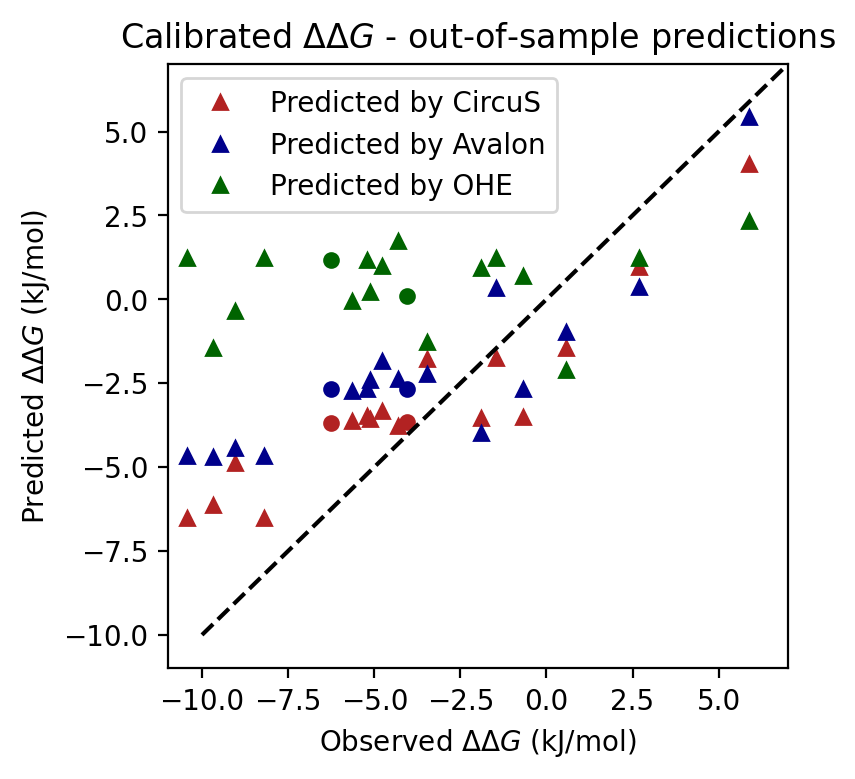

In [317]:
full_model_cv = np.loadtxt("Final_model/"+fms[8]+"/final_test.pred.gz")

x = ddg_full_train
y = np.mean(full_model_cv[:,2:], axis=1)

fig, ax = plt.subplots(figsize=(4,4), dpi=200, facecolor="white")

plt.plot(calibrate(ddg_THP_test,  data_THP_test["concentration"], 0.05,
                   cyh_calib_coef, data_THP_test["T(K)"], calib_function), test_preds_part, 
        "^", color="firebrick", markersize=5, label="Predicted by CircuS")
plt.plot(ddg_full_train[data_full_extracted.level_0[:2]], extracted_preds_part[:2], "o", color="firebrick", markersize=5)
plt.plot(ddg_full_train[data_full_extracted.level_0[2:]], extracted_preds_part[2:], "^", color="firebrick", markersize=5)
plt.plot(calibrate(ddg_THP_test,  data_THP_test["concentration"], 0.05,
                   cyh_calib_coef, data_THP_test["T(K)"], calib_function), avalon_preds_test, 
        "^", color="darkblue", markersize=5, label="Predicted by Avalon")
plt.plot(ddg_full_train[data_full_extracted.level_0[:2]], avalon_preds_extracted[:2], "o", color="darkblue", markersize=5)
plt.plot(ddg_full_train[data_full_extracted.level_0[2:]], avalon_preds_extracted[2:], "^", color="darkblue", markersize=5)
plt.plot(calibrate(ddg_THP_test,  data_THP_test["concentration"], 0.05,
                   cyh_calib_coefcyh_poptb, data_THP_test["T(K)"], calib_function), oh_preds, 
        "^", color="darkgreen", markersize=5, label="Predicted by OHE")
plt.plot(ddg_full_train[data_full_extracted.level_0[:2]], oh_preds_extracted[:2], "o", color="darkgreen", markersize=5)
plt.plot(ddg_full_train[data_full_extracted.level_0[2:]], oh_preds_extracted[2:], "^", color="darkgreen", markersize=5)
plt.plot([-10,7],[-10,7], "k--")


plt.title(r"Calibrated $\Delta \Delta G$ - out-of-sample predictions")
plt.ylabel(r"Predicted $\Delta \Delta G$ (kJ/mol)")
plt.xlabel(r"Observed $\Delta \Delta G$ (kJ/mol)")
plt.xlim([-11, 7])
plt.ylim([-11, 7])
plt.xticks(np.arange(-10,7))
plt.yticks(np.arange(-10,7))
plt.legend()
#plt.grid(color="lightgrey")
plt.xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5])
plt.yticks([-10, -7.5, -5, -2.5, 0, 2.5, 5])
plt.show()

## ColorAtom

In [17]:
from ChemInfoTools.cheminfotools.coloratom import *

In [130]:
ca = ColorAtom(is_complex=True)

In [358]:
ca.set_pipeline(best_model_full)
i, j = 3, 0

ca.output_html(data_full_train[data_full_train.name==i].iloc[j])